In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from models import basemodel, non_norm, ResnetLayer, Resnet, Resnet_regression, basemodel_regression
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pickle as pkl

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU만 사용하도록 제한
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
  except RuntimeError as e:
    # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
    print(e)

2023-10-05 12:39:29.996356: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-05 12:39:30.127746: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-05 12:39:30.159341: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-05 12:39:30.683589: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
def train_dnn(
    model, X, Y,
    test_X, test_Y, 
    # callback,
    Epoch = 50,
    cp_path = None,
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy', 'categorical_crossentropy'],
    monitor = 'val_accuracy',
    mode = 'max'
    ):
    callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = './model/' + cp_path,
        monitor= monitor,
        mode=mode,
        save_best_only = True,
        save_weigths_only = False,
    )
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    # optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    # loss = tf.keras.losses.CategoricalCrossentropy()
    model.compile(optimizer = optimizer , loss = loss, 
                metrics = metrics)
    print('X shape : ', X.shape)
    # model.build(input_shape = (1, X.shape[1]))          
    model.build(input_shape = (None, X.shape[1]))
    model.summary()
    history = model.fit(X, Y,  epochs = Epoch,
                validation_data = (test_X, test_Y),
                # callbacks = [callback, early_stopping]
                callbacks = [callback]
                )
    model = tf.keras.models.load_model(('./model/'+cp_path))
    y_pred = np.argmax(model.predict(test_X), axis = 1)
    y_gt = np.argmax(test_Y, axis = 1)
    score = accuracy_score(y_gt, y_pred)
    print('Best score : {:.4f}'.format(score))

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy ' + cp_path)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./model_plot/accuracy_' + cp_path + '.png')

    # Y_pred_label = np.array([idx2label_Dict[y_pred[i]] for i in range(len(y_pred))])
    # Y_gt_label = np.array([idx2label_Dict[y_gt[i]] for i in range(len(y_gt))])
    # cm = confusion_matrix(Y_gt_label, Y_pred_label)
    # label = ['Asphalt', 'Brick', 'Tile', 'Sandbed', 'Urethane']
    # heatmap(cm, 'Road_surface_classification', label)
    return history

def train_dnn_reg(
    model, X, Y,
    test_X, test_Y, 
    # callback,
    Epoch = 50,
    cp_path = None,
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['mae', 'mse'],
    monitor = 'val_loss',
    mode = 'min'
    ):
    callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = './model/' + cp_path,
        monitor= monitor,
        mode=mode,
        save_best_only = True,
        save_weigths_only = False,
    )
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    # optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    # loss = tf.keras.losses.CategoricalCrossentropy()
    model.compile(optimizer = optimizer , loss = loss, 
                metrics = metrics)
    print('X shape : ', X.shape)
    # model.build(input_shape = (1, X.shape[1]))          
    model.build(input_shape = (None, X.shape[1]))
    model.summary()
    history = model.fit(X, Y,  epochs = Epoch,
                validation_data = (test_X, test_Y),
                # callbacks = [callback, early_stopping]
                callbacks = [callback]
                )
    model = tf.keras.models.load_model(('./model/'+cp_path))
    y_pred = np.around(model.predict(test_X))
    y_gt = test_Y
    score = accuracy_score(y_gt, y_pred)
    print('Best score : {:.4f}'.format(score))

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model accuracy ' + cp_path)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./model_plot/accuracy_' + cp_path + '.png')

    # Y_pred_label = np.array([idx2label_Dict[y_pred[i]] for i in range(len(y_pred))])
    # Y_gt_label = np.array([idx2label_Dict[y_gt[i]] for i in range(len(y_gt))])
    # cm = confusion_matrix(Y_gt_label, Y_pred_label)
    # label = ['Asphalt', 'Brick', 'Tile', 'Sandbed', 'Urethane']
    # heatmap(cm, 'Road_surface_classification', label)
    return history

def train(
    model, X, Y,
    test_X, test_Y, 
    # callback,
    Epoch = 50,
    cp_path = None,
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy', 'categorical_crossentropy'],
    monitor = 'val_accuracy',
    mode = 'max'
    ):
    callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = './model/' + cp_path,
        monitor= monitor,
        mode=mode,
        save_best_only = True,
        save_weigths_only = False,
    )
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    # optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    # loss = tf.keras.losses.CategoricalCrossentropy()
    model.compile(optimizer = optimizer , loss = loss, 
                metrics = metrics)
    print('X shape : ', X.shape)
    # model.build(input_shape = (1, X.shape[1]))          
    model.build(input_shape = (None, X.shape[1], 1))
    model.summary()
    history = model.fit(X, Y,  epochs = Epoch,
                validation_data = (test_X, test_Y),
                callbacks = [
                    callback, 
                    # early_stopping
                    ]
                )
    model = tf.keras.models.load_model(('./model/'+cp_path))
    y_pred = np.argmax(model.predict(test_X), axis = 1)
    y_gt = np.argmax(test_Y, axis = 1)
    score = accuracy_score(y_gt, y_pred)
    print('Best score : {:.4f}'.format(score))

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy ' + cp_path)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./model_plot/accuracy_' + cp_path + '.png')

    # Y_pred_label = np.array([idx2label_Dict[y_pred[i]] for i in range(len(y_pred))])
    # Y_gt_label = np.array([idx2label_Dict[y_gt[i]] for i in range(len(y_gt))])
    # cm = confusion_matrix(Y_gt_label, Y_pred_label)
    # label = ['Asphalt', 'Brick', 'Tile', 'Sandbed', 'Urethane']
    # heatmap(cm, 'Road_surface_classification', label)
    return history

def train_regression(
    model, X, Y,
    test_X, test_Y, 
    # callback,
    Epoch = 50,
    cp_path = None,
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['mae', 'mse'],
    monitor = 'val_loss',
    mode = 'min'
    ):
    callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = './model/' + cp_path,
        monitor= monitor,
        mode=mode,
        save_best_only = True,
        save_weigths_only = False,
    )
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    # optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    # loss = tf.keras.losses.CategoricalCrossentropy()
    model.compile(optimizer = optimizer , loss = loss, 
                metrics = metrics)
    print('X shape : ', X.shape)
    # model.build(input_shape = (1, X.shape[1]))          
    model.build(input_shape = (None, X.shape[1], 1))
    model.summary()
    history = model.fit(X, Y,  epochs = Epoch,
                validation_data = (test_X, test_Y),
                callbacks = [callback, early_stopping]
                )
    model = tf.keras.models.load_model(('./model/'+cp_path))
    y_pred = np.around(model.predict(test_X))
    y_gt = test_Y
    score = accuracy_score(y_gt, y_pred)
    print('Best score : {:.4f}'.format(score))

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model accuracy ' + cp_path)
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./model_plot/accuracy_' + cp_path + '.png')

    # Y_pred_label = np.array([idx2label_Dict[y_pred[i]] for i in range(len(y_pred))])
    # Y_gt_label = np.array([idx2label_Dict[y_gt[i]] for i in range(len(y_gt))])
    # cm = confusion_matrix(Y_gt_label, Y_pred_label)
    # label = ['Asphalt', 'Brick', 'Tile', 'Sandbed', 'Urethane']
    # heatmap(cm, 'Road_surface_classification', label)
    return history

# def heatmap(matrix, title, label):
#     save_path = 'plot/cm.png'
#     df=pd.DataFrame(matrix, index = label, columns = label)
#     plt.figure(figsize=(10,10))
#     sns.heatmap(df, annot=True, fmt = 'd')
#     plt.tick_params(axis='x', top=True, labeltop = True,bottom=False, labelbottom=False)
#     plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
#     plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
#     plt.xlabel("Prediction",position = (0.5,1.0+0.05))
#     plt.ylabel("Ground Truth")
#     plt.title(title)
#     plt.savefig('cm.png', format='png', dpi=300)

In [3]:
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

In [4]:
def file_sort(path):
    file_list = os.listdir(path)
    for file in file_list:
        if os.path.isfile(os.path.join(path, file)):
            createFolder('./'+path+'/' + file[:2])
            shutil.move('./'+path+'/' + file, './'+path+'/' + file[:2] + '/' + file)

In [5]:
def file_load(path):
    data = list()
    file_list = os.listdir(path)
    for file in file_list:
        file_path = os.path.join(path,file)
        if os.path.isfile(file_path):
            temp = np.load(file_path)
            data.append(temp)
    return data

In [6]:
folder_path = 'counting_cylinder'
# folder_path = 'counting'
# folder_path = 'countingdatasmall'

In [7]:
file_sort(folder_path)

In [8]:
folder_list = os.listdir(folder_path)

In [9]:
folder_list = sorted(folder_list)

In [10]:
temp_path = os.path.join(folder_path,folder_list[1])
data = file_load(temp_path)

In [11]:
data_dict = dict()
for folder in folder_list:
    temp_path = os.path.join(folder_path,folder)
    data_dict[folder] = np.array(file_load(temp_path))

In [12]:
data_dict['02'].shape

(18, 20, 1, 301)

In [13]:
reshaped_data = dict()
for i in data_dict.keys():
    reshaped_data[i] = data_dict[i].reshape(data_dict[i].shape[0]*data_dict[i].shape[1], data_dict[i].shape[2], data_dict[i].shape[3])
    reshaped_data[i] = reshaped_data[i].reshape(reshaped_data[i].shape[0], reshaped_data[i].shape[2])

In [14]:
reshaped_data['00'].shape

(360, 301)

In [15]:
total_reshaped_data = [data for i in reshaped_data.keys() for data in reshaped_data[i]]
total_reshaped_data = np.array(total_reshaped_data)
total_reshaped_data.shape

scaler = StandardScaler()
scaler.fit(total_reshaped_data)
scaled_total_reshaped_data = scaler.transform(total_reshaped_data)
pca = PCA()
pca.fit(scaled_total_reshaped_data)

PCA()

In [16]:
pkl.dump(scaler, open('./preprocessed/scaler.pkl', 'wb'))
pkl.dump(pca, open('./preprocessed/pca.pkl', 'wb'))

In [17]:
range_fft_dict= dict()
for i in reshaped_data.keys():
    range_fft_dict[i] = np.fft.fftshift(np.fft.fft(reshaped_data[i], axis=1), axes=1)

In [18]:
reshaped_data['00'].shape

(360, 301)

In [19]:
def preprocessed(data, scaler, pca):
    # data = np.squeeze(data, axis = 1)
    data = scaler.transform(data)
    data = pca.transform(data)
    # data = np.expand_dims(data, axis = 1)
    return data



for i in reshaped_data.keys():
    reshaped_data[i] = preprocessed(reshaped_data[i], scaler, pca)

In [15]:
# # 서브플롯 그리기
# num_profiles = len(range_fft_dict)
# plt.figure(figsize=(10, 5 * num_profiles))

# for idx, (key, profile) in enumerate(range_fft_dict.items(), 1):
#     plt.subplot(num_profiles, 1, idx)
#     plt.imshow(10 * np.log10(np.abs(profile)), aspect='auto', cmap='jet', interpolation='none')
#     # plt.imshow(np.abs(profile), aspect='auto', cmap='jet', interpolation='none')
#     plt.colorbar(label="dB")
#     plt.xlabel("Range Bin")
#     plt.ylabel("Pulse Number")
#     plt.title(f"Range Profiles: {key}")

# plt.tight_layout()
# plt.show()

In [16]:
# # 그래프 그리기
# num_profiles = len(range_fft_dict)

# for idx, (key, profile) in enumerate(range_fft_dict.items(), 1):
#     fig = plt.figure(figsize=(10, 8))
#     ax = fig.add_subplot(111, projection='3d')
    
#     X = np.arange(profile.shape[1])  # Range Bin
#     Y = np.arange(profile.shape[0])  # Pulse Number
#     X, Y = np.meshgrid(X, Y)
#     Z = 10 * np.log10(np.abs(profile))
    
#     surf = ax.plot_surface(X, Y, Z, cmap='jet', linewidth=0, antialiased=False)
    
#     ax.set_xlabel("Range Bin")
#     ax.set_ylabel("Pulse Number")
#     ax.set_zlabel("Amplitude (dB)")
#     ax.set_title(f"3D Range Profiles: {key}")
#     fig.colorbar(surf, ax=ax, label="dB")

#     plt.tight_layout()
#     plt.show()

In [17]:
# num_profiles = len(reshaped_data)

# for idx, (key, profile) in enumerate(reshaped_data.items(), 1):
#     fig = plt.figure(figsize=(10, 8))
#     ax = fig.add_subplot(111, projection='3d')
    
#     X = np.arange(profile.shape[1])  # Range Bin
#     Y = np.arange(profile.shape[0])  # Pulse Number
#     X, Y = np.meshgrid(X, Y)
#     # Z = 10 * np.log10(np.abs(profile))
#     Z = np.abs(profile)
    
#     surf = ax.plot_surface(X, Y, Z, cmap='jet', linewidth=0, antialiased=False)
    
#     ax.set_xlabel("Range Bin")
#     ax.set_ylabel("Pulse Number")
#     ax.set_zlabel("Amplitude (dB)")
#     ax.set_title(f"3D Range Profiles: {key}")
#     fig.colorbar(surf, ax=ax, label="dB")

#     plt.tight_layout()
#     plt.show()

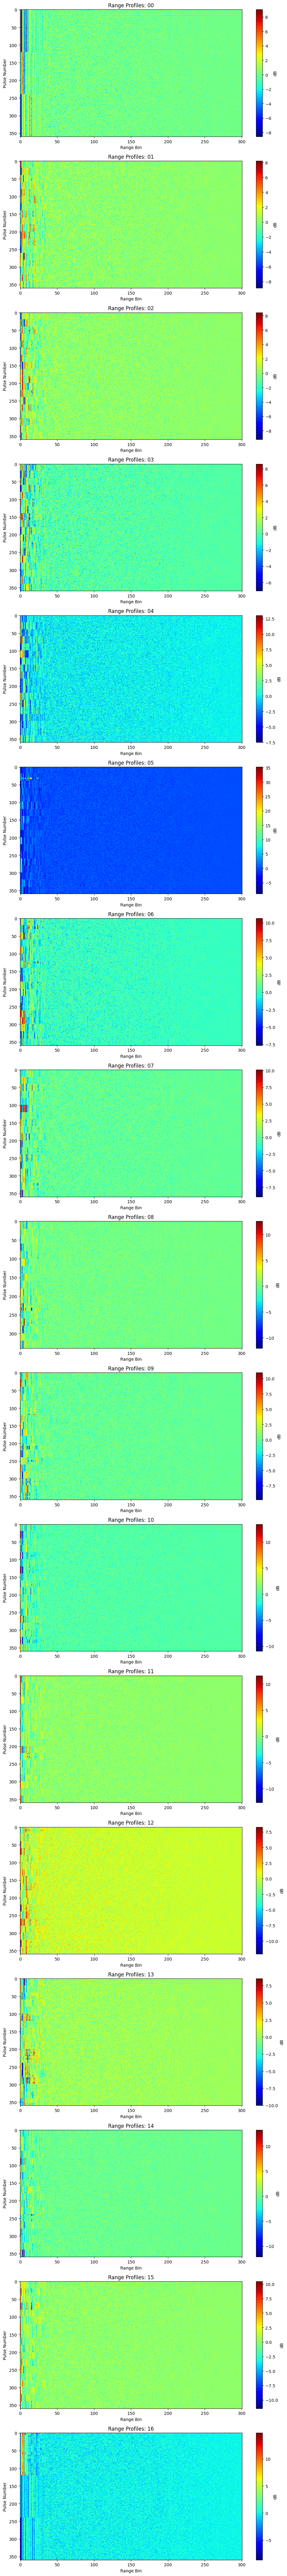

In [20]:
# 서브플롯 그리기
num_profiles = len(reshaped_data)
plt.figure(figsize=(10, 5 * num_profiles))

for idx, (key, profile) in enumerate(reshaped_data.items(), 1):
    plt.subplot(num_profiles, 1, idx)
    plt.imshow(profile, aspect='auto', cmap='jet', interpolation='none')
    # plt.imshow(np.abs(profile), aspect='auto', cmap='jet', interpolation='none')
    plt.colorbar(label="dB")
    plt.xlabel("Range Bin")
    plt.ylabel("Pulse Number")
    plt.title(f"Range Profiles: {key}")

plt.tight_layout()
plt.show()

In [16]:
# model = basemodel(len(range_fft_dict))

In [21]:
def make_dataset(data_dict):
    # x = list()
    y = list()
    x = None
    for key, data in data_dict.items():
        if x is None:
            x = data
        else:
            x = np.concatenate((x, data), axis = 0)
        for i in range(data.shape[0]):
            y.append(to_categorical(int(key), num_classes=len(data_dict)))
    print(x.shape)
    y = np.array(y)
    X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    return X_train, X_test, Y_train, Y_test

In [22]:
# X_train, X_test, Y_train, Y_test = make_dataset(range_fft_dict)
# X_train, X_test  = 10 * np.log10(X_train), 10 * np.log10(X_test)
X_train, X_test, Y_train, Y_test = make_dataset(reshaped_data)
X_train, X_test = np.expand_dims(X_train, axis = 2), np.expand_dims(X_test, axis = 2)

(6100, 301)


X shape :  (4880, 301)
Model: "basemodel_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  multiple                 603       
 ion)                                                            
                                                                 
 dense_14 (Dense)            multiple                  2416      
                                                                 
 batch_normalization_6 (Batc  multiple                 32        
 hNormalization)                                                 
                                                                 
 dense_15 (Dense)            multiple                  144       
                                                                 
 dense_16 (Dense)            multiple                  544       
                                                                 
 dense_17 (Dense)            mul

INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 3s 16ms/step - loss: 2.4141 - accuracy: 0.2199 - categorical_crossentropy: 2.4141 - val_loss: 1.9179 - val_accuracy: 0.3426 - val_categorical_crossentropy: 1.9179
Epoch 2/500
152/153 [============================>.] - ETA: 0s - loss: 1.6812 - accuracy: 0.4280 - categorical_crossentropy: 1.6812INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 1.6804 - accuracy: 0.4281 - categorical_crossentropy: 1.6804 - val_loss: 1.5453 - val_accuracy: 0.4525 - val_categorical_crossentropy: 1.5453
Epoch 3/500
153/153 [==============================] - ETA: 0s - loss: 1.4048 - accuracy: 0.5072 - categorical_crossentropy: 1.4048INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 16ms/step - loss: 1.4048 - accuracy: 0.5072 - categorical_crossentropy: 1.4048 - val_loss: 1.3806 - val_accuracy: 0.5164 - val_categorical_crossentropy: 1.3806
Epoch 4/500
152/153 [============================>.] - ETA: 0s - loss: 1.2425 - accuracy: 0.5613 - categorical_crossentropy: 1.2425INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 1.2413 - accuracy: 0.5619 - categorical_crossentropy: 1.2413 - val_loss: 1.3215 - val_accuracy: 0.5303 - val_categorical_crossentropy: 1.3215
Epoch 5/500
148/153 [============================>.] - ETA: 0s - loss: 1.1348 - accuracy: 0.5925 - categorical_crossentropy: 1.1348INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 1.1343 - accuracy: 0.5916 - categorical_crossentropy: 1.1343 - val_loss: 1.2606 - val_accuracy: 0.5410 - val_categorical_crossentropy: 1.2606
Epoch 6/500
149/153 [============================>.] - ETA: 0s - loss: 1.0359 - accuracy: 0.6391 - categorical_crossentropy: 1.0359INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 1.0422 - accuracy: 0.6373 - categorical_crossentropy: 1.0422 - val_loss: 1.2376 - val_accuracy: 0.5639 - val_categorical_crossentropy: 1.2376
Epoch 7/500
153/153 [==============================] - 1s 9ms/step - loss: 0.9990 - accuracy: 0.6410 - categorical_crossentropy: 0.9990 - val_loss: 1.2238 - val_accuracy: 0.5631 - val_categorical_crossentropy: 1.2238
Epoch 8/500
153/153 [==============================] - ETA: 0s - loss: 0.9240 - accuracy: 0.6695 - categorical_crossentropy: 0.9240INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 15ms/step - loss: 0.9240 - accuracy: 0.6695 - categorical_crossentropy: 0.9240 - val_loss: 1.1861 - val_accuracy: 0.5746 - val_categorical_crossentropy: 1.1861
Epoch 9/500
148/153 [============================>.] - ETA: 0s - loss: 0.8986 - accuracy: 0.6803 - categorical_crossentropy: 0.8986INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 15ms/step - loss: 0.8978 - accuracy: 0.6801 - categorical_crossentropy: 0.8978 - val_loss: 1.1493 - val_accuracy: 0.5910 - val_categorical_crossentropy: 1.1493
Epoch 10/500
147/153 [===========================>..] - ETA: 0s - loss: 0.8669 - accuracy: 0.6905 - categorical_crossentropy: 0.8669INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 0.8686 - accuracy: 0.6895 - categorical_crossentropy: 0.8686 - val_loss: 1.1476 - val_accuracy: 0.5967 - val_categorical_crossentropy: 1.1476
Epoch 11/500
152/153 [============================>.] - ETA: 0s - loss: 0.8363 - accuracy: 0.6988 - categorical_crossentropy: 0.8363INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 3s 17ms/step - loss: 0.8373 - accuracy: 0.6988 - categorical_crossentropy: 0.8373 - val_loss: 1.1293 - val_accuracy: 0.6066 - val_categorical_crossentropy: 1.1293
Epoch 12/500
150/153 [============================>.] - ETA: 0s - loss: 0.8080 - accuracy: 0.7085 - categorical_crossentropy: 0.8080INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 0.8127 - accuracy: 0.7072 - categorical_crossentropy: 0.8127 - val_loss: 1.1290 - val_accuracy: 0.6074 - val_categorical_crossentropy: 1.1290
Epoch 13/500
151/153 [============================>.] - ETA: 0s - loss: 0.8123 - accuracy: 0.7165 - categorical_crossentropy: 0.8123INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 0.8119 - accuracy: 0.7160 - categorical_crossentropy: 0.8119 - val_loss: 1.0903 - val_accuracy: 0.6303 - val_categorical_crossentropy: 1.0903
Epoch 14/500
153/153 [==============================] - 1s 9ms/step - loss: 0.7737 - accuracy: 0.7207 - categorical_crossentropy: 0.7737 - val_loss: 1.0927 - val_accuracy: 0.6189 - val_categorical_crossentropy: 1.0927
Epoch 15/500
153/153 [==============================] - 1s 9ms/step - loss: 0.7476 - accuracy: 0.7348 - categorical_crossentropy: 0.7476 - val_loss: 1.1087 - val_accuracy: 0.6197 - val_categorical_crossentropy: 1.1087
Epoch 16/500
153/153 [==============================] - ETA: 0s - loss: 0.7251 - accuracy: 0.7389 - categorical_crossentropy: 0.7251INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 0.7251 - accuracy: 0.7389 - categorical_crossentropy: 0.7251 - val_loss: 1.0635 - val_accuracy: 0.6369 - val_categorical_crossentropy: 1.0635
Epoch 17/500
148/153 [============================>.] - ETA: 0s - loss: 0.7189 - accuracy: 0.7401 - categorical_crossentropy: 0.7189INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 0.7203 - accuracy: 0.7393 - categorical_crossentropy: 0.7203 - val_loss: 1.0680 - val_accuracy: 0.6516 - val_categorical_crossentropy: 1.0680
Epoch 18/500
153/153 [==============================] - 1s 9ms/step - loss: 0.7194 - accuracy: 0.7385 - categorical_crossentropy: 0.7194 - val_loss: 1.0552 - val_accuracy: 0.6508 - val_categorical_crossentropy: 1.0552
Epoch 19/500
148/153 [============================>.] - ETA: 0s - loss: 0.6776 - accuracy: 0.7502 - categorical_crossentropy: 0.6776INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 0.6828 - accuracy: 0.7494 - categorical_crossentropy: 0.6828 - val_loss: 1.0478 - val_accuracy: 0.6533 - val_categorical_crossentropy: 1.0478
Epoch 20/500
149/153 [============================>.] - ETA: 0s - loss: 0.6680 - accuracy: 0.7599 - categorical_crossentropy: 0.6680INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 3s 16ms/step - loss: 0.6674 - accuracy: 0.7596 - categorical_crossentropy: 0.6674 - val_loss: 1.0113 - val_accuracy: 0.6607 - val_categorical_crossentropy: 1.0113
Epoch 21/500
148/153 [============================>.] - ETA: 0s - loss: 0.6834 - accuracy: 0.7561 - categorical_crossentropy: 0.6834INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 0.6851 - accuracy: 0.7555 - categorical_crossentropy: 0.6851 - val_loss: 1.0370 - val_accuracy: 0.6615 - val_categorical_crossentropy: 1.0370
Epoch 22/500
148/153 [============================>.] - ETA: 0s - loss: 0.6331 - accuracy: 0.7741 - categorical_crossentropy: 0.6331INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 0.6357 - accuracy: 0.7721 - categorical_crossentropy: 0.6357 - val_loss: 1.0086 - val_accuracy: 0.6623 - val_categorical_crossentropy: 1.0086
Epoch 23/500
149/153 [============================>.] - ETA: 0s - loss: 0.6539 - accuracy: 0.7649 - categorical_crossentropy: 0.6539INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 0.6576 - accuracy: 0.7629 - categorical_crossentropy: 0.6576 - val_loss: 0.9889 - val_accuracy: 0.6697 - val_categorical_crossentropy: 0.9889
Epoch 24/500
152/153 [============================>.] - ETA: 0s - loss: 0.6148 - accuracy: 0.7864 - categorical_crossentropy: 0.6148INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 0.6150 - accuracy: 0.7863 - categorical_crossentropy: 0.6150 - val_loss: 0.9894 - val_accuracy: 0.6779 - val_categorical_crossentropy: 0.9894
Epoch 25/500
148/153 [============================>.] - ETA: 0s - loss: 0.6308 - accuracy: 0.7741 - categorical_crossentropy: 0.6308INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 0.6356 - accuracy: 0.7725 - categorical_crossentropy: 0.6356 - val_loss: 0.9712 - val_accuracy: 0.6992 - val_categorical_crossentropy: 0.9712
Epoch 26/500
153/153 [==============================] - 1s 9ms/step - loss: 0.6133 - accuracy: 0.7805 - categorical_crossentropy: 0.6133 - val_loss: 0.9814 - val_accuracy: 0.6762 - val_categorical_crossentropy: 0.9814
Epoch 27/500
153/153 [==============================] - 1s 10ms/step - loss: 0.6135 - accuracy: 0.7838 - categorical_crossentropy: 0.6135 - val_loss: 0.9509 - val_accuracy: 0.6910 - val_categorical_crossentropy: 0.9509
Epoch 28/500
153/153 [==============================] - 1s 9ms/step - loss: 0.6015 - accuracy: 0.7875 - categorical_crossentropy: 0.6015 - val_loss: 0.9700 - val_accuracy: 0.6852 - val_categorical_crossentropy: 0.9700
Epoch 29/500
153/153 [==============================] - 1s 9ms/step - loss: 0.5878 - accuracy: 0.7928 - categorical_crossentropy: 0.5878 - 

INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 0.5763 - accuracy: 0.7941 - categorical_crossentropy: 0.5763 - val_loss: 0.9354 - val_accuracy: 0.7008 - val_categorical_crossentropy: 0.9354
Epoch 32/500
149/153 [============================>.] - ETA: 0s - loss: 0.5467 - accuracy: 0.8085 - categorical_crossentropy: 0.5467INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 16ms/step - loss: 0.5471 - accuracy: 0.8066 - categorical_crossentropy: 0.5471 - val_loss: 0.9039 - val_accuracy: 0.7115 - val_categorical_crossentropy: 0.9039
Epoch 33/500
153/153 [==============================] - 1s 9ms/step - loss: 0.5392 - accuracy: 0.8025 - categorical_crossentropy: 0.5392 - val_loss: 0.9279 - val_accuracy: 0.7033 - val_categorical_crossentropy: 0.9279
Epoch 34/500
153/153 [==============================] - 1s 10ms/step - loss: 0.5277 - accuracy: 0.8160 - categorical_crossentropy: 0.5277 - val_loss: 0.9094 - val_accuracy: 0.7074 - val_categorical_crossentropy: 0.9094
Epoch 35/500
153/153 [==============================] - 1s 9ms/step - loss: 0.5231 - accuracy: 0.8189 - categorical_crossentropy: 0.5231 - val_loss: 0.8957 - val_accuracy: 0.7082 - val_categorical_crossentropy: 0.8957
Epoch 36/500
153/153 [==============================] - 1s 10ms/step - loss: 0.4975 - accuracy: 0.8260 - categorical_crossentropy: 0.4975 -

INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 0.5224 - accuracy: 0.8186 - categorical_crossentropy: 0.5224 - val_loss: 0.8666 - val_accuracy: 0.7221 - val_categorical_crossentropy: 0.8666
Epoch 38/500
153/153 [==============================] - 1s 9ms/step - loss: 0.5013 - accuracy: 0.8236 - categorical_crossentropy: 0.5013 - val_loss: 0.8809 - val_accuracy: 0.7074 - val_categorical_crossentropy: 0.8809
Epoch 39/500
147/153 [===========================>..] - ETA: 0s - loss: 0.5065 - accuracy: 0.8168 - categorical_crossentropy: 0.5065INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 0.5083 - accuracy: 0.8168 - categorical_crossentropy: 0.5083 - val_loss: 0.8471 - val_accuracy: 0.7262 - val_categorical_crossentropy: 0.8471
Epoch 40/500
153/153 [==============================] - 1s 9ms/step - loss: 0.4956 - accuracy: 0.8215 - categorical_crossentropy: 0.4956 - val_loss: 0.8557 - val_accuracy: 0.7189 - val_categorical_crossentropy: 0.8557
Epoch 41/500
153/153 [==============================] - 1s 9ms/step - loss: 0.4933 - accuracy: 0.8230 - categorical_crossentropy: 0.4933 - val_loss: 0.8321 - val_accuracy: 0.7262 - val_categorical_crossentropy: 0.8321
Epoch 42/500
147/153 [===========================>..] - ETA: 0s - loss: 0.4466 - accuracy: 0.8380 - categorical_crossentropy: 0.4466INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 15ms/step - loss: 0.4498 - accuracy: 0.8361 - categorical_crossentropy: 0.4498 - val_loss: 0.8631 - val_accuracy: 0.7311 - val_categorical_crossentropy: 0.8631
Epoch 43/500
153/153 [==============================] - 1s 9ms/step - loss: 0.4741 - accuracy: 0.8334 - categorical_crossentropy: 0.4741 - val_loss: 0.8516 - val_accuracy: 0.7180 - val_categorical_crossentropy: 0.8516
Epoch 44/500
151/153 [============================>.] - ETA: 0s - loss: 0.4505 - accuracy: 0.8406 - categorical_crossentropy: 0.4505INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 0.4498 - accuracy: 0.8408 - categorical_crossentropy: 0.4498 - val_loss: 0.8353 - val_accuracy: 0.7320 - val_categorical_crossentropy: 0.8353
Epoch 45/500
151/153 [============================>.] - ETA: 0s - loss: 0.4609 - accuracy: 0.8396 - categorical_crossentropy: 0.4609INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 15ms/step - loss: 0.4629 - accuracy: 0.8389 - categorical_crossentropy: 0.4629 - val_loss: 0.8157 - val_accuracy: 0.7434 - val_categorical_crossentropy: 0.8157
Epoch 46/500
151/153 [============================>.] - ETA: 0s - loss: 0.4581 - accuracy: 0.8380 - categorical_crossentropy: 0.4581INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 15ms/step - loss: 0.4603 - accuracy: 0.8381 - categorical_crossentropy: 0.4603 - val_loss: 0.8200 - val_accuracy: 0.7451 - val_categorical_crossentropy: 0.8200
Epoch 47/500
153/153 [==============================] - 1s 10ms/step - loss: 0.4526 - accuracy: 0.8367 - categorical_crossentropy: 0.4526 - val_loss: 0.8259 - val_accuracy: 0.7320 - val_categorical_crossentropy: 0.8259
Epoch 48/500
153/153 [==============================] - 1s 10ms/step - loss: 0.4336 - accuracy: 0.8428 - categorical_crossentropy: 0.4336 - val_loss: 0.8027 - val_accuracy: 0.7434 - val_categorical_crossentropy: 0.8027
Epoch 49/500
153/153 [==============================] - ETA: 0s - loss: 0.4417 - accuracy: 0.8402 - categorical_crossentropy: 0.4417INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 3s 17ms/step - loss: 0.4417 - accuracy: 0.8402 - categorical_crossentropy: 0.4417 - val_loss: 0.7860 - val_accuracy: 0.7484 - val_categorical_crossentropy: 0.7860
Epoch 50/500
153/153 [==============================] - 1s 10ms/step - loss: 0.4243 - accuracy: 0.8516 - categorical_crossentropy: 0.4243 - val_loss: 0.8379 - val_accuracy: 0.7426 - val_categorical_crossentropy: 0.8379
Epoch 51/500
153/153 [==============================] - 1s 9ms/step - loss: 0.4367 - accuracy: 0.8418 - categorical_crossentropy: 0.4367 - val_loss: 0.7918 - val_accuracy: 0.7369 - val_categorical_crossentropy: 0.7918
Epoch 52/500
153/153 [==============================] - 1s 10ms/step - loss: 0.4249 - accuracy: 0.8449 - categorical_crossentropy: 0.4249 - val_loss: 0.7876 - val_accuracy: 0.7459 - val_categorical_crossentropy: 0.7876
Epoch 53/500
153/153 [==============================] - 1s 9ms/step - loss: 0.4024 - accuracy: 0.8578 - categorical_crossentropy: 0.4024 -

INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 15ms/step - loss: 0.4149 - accuracy: 0.8512 - categorical_crossentropy: 0.4149 - val_loss: 0.7748 - val_accuracy: 0.7508 - val_categorical_crossentropy: 0.7748
Epoch 55/500
153/153 [==============================] - 1s 9ms/step - loss: 0.3964 - accuracy: 0.8561 - categorical_crossentropy: 0.3964 - val_loss: 0.7791 - val_accuracy: 0.7393 - val_categorical_crossentropy: 0.7791
Epoch 56/500
147/153 [===========================>..] - ETA: 0s - loss: 0.4030 - accuracy: 0.8595 - categorical_crossentropy: 0.4030INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 0.4051 - accuracy: 0.8582 - categorical_crossentropy: 0.4051 - val_loss: 0.7667 - val_accuracy: 0.7615 - val_categorical_crossentropy: 0.7667
Epoch 57/500
153/153 [==============================] - 1s 9ms/step - loss: 0.4021 - accuracy: 0.8547 - categorical_crossentropy: 0.4021 - val_loss: 0.7689 - val_accuracy: 0.7590 - val_categorical_crossentropy: 0.7689
Epoch 58/500
153/153 [==============================] - 1s 9ms/step - loss: 0.3791 - accuracy: 0.8662 - categorical_crossentropy: 0.3791 - val_loss: 0.7647 - val_accuracy: 0.7508 - val_categorical_crossentropy: 0.7647
Epoch 59/500
153/153 [==============================] - 1s 9ms/step - loss: 0.3954 - accuracy: 0.8566 - categorical_crossentropy: 0.3954 - val_loss: 0.7541 - val_accuracy: 0.7607 - val_categorical_crossentropy: 0.7541
Epoch 60/500
148/153 [============================>.] - ETA: 0s - loss: 0.3854 - accuracy: 0.8680 - categorical_crossentropy: 0.3854INFO:ten

INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 0.3868 - accuracy: 0.8672 - categorical_crossentropy: 0.3868 - val_loss: 0.7600 - val_accuracy: 0.7689 - val_categorical_crossentropy: 0.7600
Epoch 61/500
153/153 [==============================] - 1s 9ms/step - loss: 0.3628 - accuracy: 0.8742 - categorical_crossentropy: 0.3628 - val_loss: 0.7680 - val_accuracy: 0.7672 - val_categorical_crossentropy: 0.7680
Epoch 62/500
153/153 [==============================] - 1s 9ms/step - loss: 0.3668 - accuracy: 0.8723 - categorical_crossentropy: 0.3668 - val_loss: 0.7655 - val_accuracy: 0.7549 - val_categorical_crossentropy: 0.7655
Epoch 63/500
153/153 [==============================] - 1s 9ms/step - loss: 0.3688 - accuracy: 0.8672 - categorical_crossentropy: 0.3688 - val_loss: 0.7900 - val_accuracy: 0.7557 - val_categorical_crossentropy: 0.7900
Epoch 64/500
153/153 [==============================] - 1s 9ms/step - loss: 0.3555 - accuracy: 0.8793 - categorical_crossentropy: 0.3555 - v

INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 0.3796 - accuracy: 0.8609 - categorical_crossentropy: 0.3796 - val_loss: 0.7231 - val_accuracy: 0.7738 - val_categorical_crossentropy: 0.7231
Epoch 67/500
153/153 [==============================] - 1s 9ms/step - loss: 0.3787 - accuracy: 0.8684 - categorical_crossentropy: 0.3787 - val_loss: 0.7644 - val_accuracy: 0.7664 - val_categorical_crossentropy: 0.7644
Epoch 68/500
153/153 [==============================] - 1s 9ms/step - loss: 0.3556 - accuracy: 0.8682 - categorical_crossentropy: 0.3556 - val_loss: 0.7317 - val_accuracy: 0.7697 - val_categorical_crossentropy: 0.7317
Epoch 69/500
153/153 [==============================] - 1s 10ms/step - loss: 0.3459 - accuracy: 0.8818 - categorical_crossentropy: 0.3459 - val_loss: 0.7365 - val_accuracy: 0.7713 - val_categorical_crossentropy: 0.7365
Epoch 70/500
150/153 [============================>.] - ETA: 0s - loss: 0.3484 - accuracy: 0.8727 - categorical_crossentropy: 0.3484INFO:te

INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 0.3503 - accuracy: 0.8721 - categorical_crossentropy: 0.3503 - val_loss: 0.7281 - val_accuracy: 0.7770 - val_categorical_crossentropy: 0.7281
Epoch 71/500
151/153 [============================>.] - ETA: 0s - loss: 0.3426 - accuracy: 0.8810 - categorical_crossentropy: 0.3426INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 15ms/step - loss: 0.3426 - accuracy: 0.8809 - categorical_crossentropy: 0.3426 - val_loss: 0.7115 - val_accuracy: 0.7787 - val_categorical_crossentropy: 0.7115
Epoch 72/500
153/153 [==============================] - 1s 9ms/step - loss: 0.3487 - accuracy: 0.8762 - categorical_crossentropy: 0.3487 - val_loss: 0.7214 - val_accuracy: 0.7779 - val_categorical_crossentropy: 0.7214
Epoch 73/500
153/153 [==============================] - 1s 10ms/step - loss: 0.3670 - accuracy: 0.8736 - categorical_crossentropy: 0.3670 - val_loss: 0.7194 - val_accuracy: 0.7689 - val_categorical_crossentropy: 0.7194
Epoch 74/500
148/153 [============================>.] - ETA: 0s - loss: 0.3500 - accuracy: 0.8752 - categorical_crossentropy: 0.3500INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 3s 17ms/step - loss: 0.3511 - accuracy: 0.8742 - categorical_crossentropy: 0.3511 - val_loss: 0.7136 - val_accuracy: 0.7803 - val_categorical_crossentropy: 0.7136
Epoch 75/500
153/153 [==============================] - ETA: 0s - loss: 0.3407 - accuracy: 0.8760 - categorical_crossentropy: 0.3407INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 0.3407 - accuracy: 0.8760 - categorical_crossentropy: 0.3407 - val_loss: 0.6982 - val_accuracy: 0.7861 - val_categorical_crossentropy: 0.6982
Epoch 76/500
149/153 [============================>.] - ETA: 0s - loss: 0.3555 - accuracy: 0.8723 - categorical_crossentropy: 0.3555INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 15ms/step - loss: 0.3552 - accuracy: 0.8721 - categorical_crossentropy: 0.3552 - val_loss: 0.6811 - val_accuracy: 0.7918 - val_categorical_crossentropy: 0.6811
Epoch 77/500
153/153 [==============================] - 1s 9ms/step - loss: 0.3647 - accuracy: 0.8744 - categorical_crossentropy: 0.3647 - val_loss: 0.6758 - val_accuracy: 0.7910 - val_categorical_crossentropy: 0.6758
Epoch 78/500
153/153 [==============================] - ETA: 0s - loss: 0.3404 - accuracy: 0.8756 - categorical_crossentropy: 0.3404INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 15ms/step - loss: 0.3404 - accuracy: 0.8756 - categorical_crossentropy: 0.3404 - val_loss: 0.6590 - val_accuracy: 0.8033 - val_categorical_crossentropy: 0.6590
Epoch 79/500
153/153 [==============================] - 1s 9ms/step - loss: 0.3162 - accuracy: 0.8887 - categorical_crossentropy: 0.3162 - val_loss: 0.6793 - val_accuracy: 0.7959 - val_categorical_crossentropy: 0.6793
Epoch 80/500
153/153 [==============================] - 1s 9ms/step - loss: 0.3191 - accuracy: 0.8891 - categorical_crossentropy: 0.3191 - val_loss: 0.6625 - val_accuracy: 0.7852 - val_categorical_crossentropy: 0.6625
Epoch 81/500
149/153 [============================>.] - ETA: 0s - loss: 0.3078 - accuracy: 0.8909 - categorical_crossentropy: 0.3078INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 15ms/step - loss: 0.3138 - accuracy: 0.8891 - categorical_crossentropy: 0.3138 - val_loss: 0.6518 - val_accuracy: 0.8041 - val_categorical_crossentropy: 0.6518
Epoch 82/500
153/153 [==============================] - 1s 9ms/step - loss: 0.3245 - accuracy: 0.8871 - categorical_crossentropy: 0.3245 - val_loss: 0.6741 - val_accuracy: 0.7943 - val_categorical_crossentropy: 0.6741
Epoch 83/500
153/153 [==============================] - 1s 9ms/step - loss: 0.3322 - accuracy: 0.8826 - categorical_crossentropy: 0.3322 - val_loss: 0.6742 - val_accuracy: 0.7877 - val_categorical_crossentropy: 0.6742
Epoch 84/500
153/153 [==============================] - 1s 10ms/step - loss: 0.3243 - accuracy: 0.8865 - categorical_crossentropy: 0.3243 - val_loss: 0.6642 - val_accuracy: 0.7893 - val_categorical_crossentropy: 0.6642
Epoch 85/500
153/153 [==============================] - 1s 9ms/step - loss: 0.3235 - accuracy: 0.8811 - categorical_crossentropy: 0.3235 - 

INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 0.2968 - accuracy: 0.8951 - categorical_crossentropy: 0.2968 - val_loss: 0.6462 - val_accuracy: 0.8074 - val_categorical_crossentropy: 0.6462
Epoch 89/500
153/153 [==============================] - 1s 9ms/step - loss: 0.2964 - accuracy: 0.8969 - categorical_crossentropy: 0.2964 - val_loss: 0.6367 - val_accuracy: 0.8016 - val_categorical_crossentropy: 0.6367
Epoch 90/500
153/153 [==============================] - 1s 9ms/step - loss: 0.3010 - accuracy: 0.8941 - categorical_crossentropy: 0.3010 - val_loss: 0.6386 - val_accuracy: 0.8033 - val_categorical_crossentropy: 0.6386
Epoch 91/500
148/153 [============================>.] - ETA: 0s - loss: 0.2978 - accuracy: 0.8917 - categorical_crossentropy: 0.2978INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 3s 17ms/step - loss: 0.2975 - accuracy: 0.8924 - categorical_crossentropy: 0.2975 - val_loss: 0.6206 - val_accuracy: 0.8090 - val_categorical_crossentropy: 0.6206
Epoch 92/500
149/153 [============================>.] - ETA: 0s - loss: 0.2783 - accuracy: 0.9039 - categorical_crossentropy: 0.2783INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 15ms/step - loss: 0.2791 - accuracy: 0.9033 - categorical_crossentropy: 0.2791 - val_loss: 0.6377 - val_accuracy: 0.8107 - val_categorical_crossentropy: 0.6377
Epoch 93/500
153/153 [==============================] - ETA: 0s - loss: 0.2969 - accuracy: 0.8934 - categorical_crossentropy: 0.2969INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 0.2969 - accuracy: 0.8934 - categorical_crossentropy: 0.2969 - val_loss: 0.5987 - val_accuracy: 0.8205 - val_categorical_crossentropy: 0.5987
Epoch 94/500
153/153 [==============================] - 1s 9ms/step - loss: 0.3151 - accuracy: 0.8961 - categorical_crossentropy: 0.3151 - val_loss: 0.6133 - val_accuracy: 0.8025 - val_categorical_crossentropy: 0.6133
Epoch 95/500
153/153 [==============================] - 1s 9ms/step - loss: 0.2839 - accuracy: 0.8996 - categorical_crossentropy: 0.2839 - val_loss: 0.6242 - val_accuracy: 0.8041 - val_categorical_crossentropy: 0.6242
Epoch 96/500
153/153 [==============================] - 1s 9ms/step - loss: 0.2818 - accuracy: 0.9035 - categorical_crossentropy: 0.2818 - val_loss: 0.6335 - val_accuracy: 0.8090 - val_categorical_crossentropy: 0.6335
Epoch 97/500
153/153 [==============================] - 1s 9ms/step - loss: 0.2938 - accuracy: 0.8986 - categorical_crossentropy: 0.2938 - v

INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 0.2372 - accuracy: 0.9119 - categorical_crossentropy: 0.2372 - val_loss: 0.6073 - val_accuracy: 0.8213 - val_categorical_crossentropy: 0.6073
Epoch 104/500
153/153 [==============================] - 1s 10ms/step - loss: 0.2595 - accuracy: 0.9061 - categorical_crossentropy: 0.2595 - val_loss: 0.6122 - val_accuracy: 0.8213 - val_categorical_crossentropy: 0.6122
Epoch 105/500
153/153 [==============================] - 1s 10ms/step - loss: 0.2580 - accuracy: 0.9090 - categorical_crossentropy: 0.2580 - val_loss: 0.6547 - val_accuracy: 0.8098 - val_categorical_crossentropy: 0.6547
Epoch 106/500
153/153 [==============================] - 1s 10ms/step - loss: 0.2804 - accuracy: 0.9004 - categorical_crossentropy: 0.2804 - val_loss: 0.6285 - val_accuracy: 0.8107 - val_categorical_crossentropy: 0.6285
Epoch 107/500
153/153 [==============================] - 1s 9ms/step - loss: 0.2813 - accuracy: 0.9025 - categorical_crossentropy: 0.2

INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 0.2692 - accuracy: 0.9045 - categorical_crossentropy: 0.2692 - val_loss: 0.6173 - val_accuracy: 0.8246 - val_categorical_crossentropy: 0.6173
Epoch 109/500
153/153 [==============================] - 1s 9ms/step - loss: 0.2721 - accuracy: 0.9057 - categorical_crossentropy: 0.2721 - val_loss: 0.6446 - val_accuracy: 0.8238 - val_categorical_crossentropy: 0.6446
Epoch 110/500
153/153 [==============================] - 1s 9ms/step - loss: 0.2786 - accuracy: 0.9010 - categorical_crossentropy: 0.2786 - val_loss: 0.6227 - val_accuracy: 0.8139 - val_categorical_crossentropy: 0.6227
Epoch 111/500
153/153 [==============================] - 1s 9ms/step - loss: 0.2605 - accuracy: 0.9086 - categorical_crossentropy: 0.2605 - val_loss: 0.6316 - val_accuracy: 0.8123 - val_categorical_crossentropy: 0.6316
Epoch 112/500
153/153 [==============================] - 1s 9ms/step - loss: 0.2621 - accuracy: 0.9098 - categorical_crossentropy: 0.2621

INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 15ms/step - loss: 0.2515 - accuracy: 0.9102 - categorical_crossentropy: 0.2515 - val_loss: 0.6201 - val_accuracy: 0.8279 - val_categorical_crossentropy: 0.6201
Epoch 121/500
153/153 [==============================] - 1s 9ms/step - loss: 0.2348 - accuracy: 0.9176 - categorical_crossentropy: 0.2348 - val_loss: 0.5935 - val_accuracy: 0.8189 - val_categorical_crossentropy: 0.5935
Epoch 122/500
153/153 [==============================] - 1s 10ms/step - loss: 0.2516 - accuracy: 0.9100 - categorical_crossentropy: 0.2516 - val_loss: 0.6310 - val_accuracy: 0.8213 - val_categorical_crossentropy: 0.6310
Epoch 123/500
153/153 [==============================] - 1s 10ms/step - loss: 0.2723 - accuracy: 0.9025 - categorical_crossentropy: 0.2723 - val_loss: 0.6001 - val_accuracy: 0.8156 - val_categorical_crossentropy: 0.6001
Epoch 124/500
151/153 [============================>.] - ETA: 0s - loss: 0.2469 - accuracy: 0.9133 - categorical_crossentropy: 0.2469IN

INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 0.2476 - accuracy: 0.9129 - categorical_crossentropy: 0.2476 - val_loss: 0.5912 - val_accuracy: 0.8303 - val_categorical_crossentropy: 0.5912
Epoch 125/500
153/153 [==============================] - 1s 9ms/step - loss: 0.2533 - accuracy: 0.9088 - categorical_crossentropy: 0.2533 - val_loss: 0.6021 - val_accuracy: 0.8295 - val_categorical_crossentropy: 0.6021
Epoch 126/500
148/153 [============================>.] - ETA: 0s - loss: 0.2430 - accuracy: 0.9109 - categorical_crossentropy: 0.2430INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 3s 17ms/step - loss: 0.2467 - accuracy: 0.9105 - categorical_crossentropy: 0.2467 - val_loss: 0.5723 - val_accuracy: 0.8418 - val_categorical_crossentropy: 0.5723
Epoch 127/500
153/153 [==============================] - 1s 9ms/step - loss: 0.2552 - accuracy: 0.9119 - categorical_crossentropy: 0.2552 - val_loss: 0.5645 - val_accuracy: 0.8287 - val_categorical_crossentropy: 0.5645
Epoch 128/500
153/153 [==============================] - 1s 9ms/step - loss: 0.2493 - accuracy: 0.9115 - categorical_crossentropy: 0.2493 - val_loss: 0.5696 - val_accuracy: 0.8279 - val_categorical_crossentropy: 0.5696
Epoch 129/500
153/153 [==============================] - 1s 9ms/step - loss: 0.2353 - accuracy: 0.9125 - categorical_crossentropy: 0.2353 - val_loss: 0.5562 - val_accuracy: 0.8320 - val_categorical_crossentropy: 0.5562
Epoch 130/500
153/153 [==============================] - 1s 9ms/step - loss: 0.2489 - accuracy: 0.9154 - categorical_crossentropy: 0.2489

INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 15ms/step - loss: 0.2326 - accuracy: 0.9189 - categorical_crossentropy: 0.2326 - val_loss: 0.5528 - val_accuracy: 0.8426 - val_categorical_crossentropy: 0.5528
Epoch 148/500
153/153 [==============================] - 1s 9ms/step - loss: 0.2069 - accuracy: 0.9236 - categorical_crossentropy: 0.2069 - val_loss: 0.5596 - val_accuracy: 0.8377 - val_categorical_crossentropy: 0.5596
Epoch 149/500
153/153 [==============================] - 1s 9ms/step - loss: 0.2193 - accuracy: 0.9238 - categorical_crossentropy: 0.2193 - val_loss: 0.5670 - val_accuracy: 0.8426 - val_categorical_crossentropy: 0.5670
Epoch 150/500
153/153 [==============================] - 1s 9ms/step - loss: 0.2079 - accuracy: 0.9303 - categorical_crossentropy: 0.2079 - val_loss: 0.5848 - val_accuracy: 0.8311 - val_categorical_crossentropy: 0.5848
Epoch 151/500
153/153 [==============================] - 1s 9ms/step - loss: 0.2195 - accuracy: 0.9277 - categorical_crossentropy: 0.2195

INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 0.2056 - accuracy: 0.9254 - categorical_crossentropy: 0.2056 - val_loss: 0.5588 - val_accuracy: 0.8443 - val_categorical_crossentropy: 0.5588
Epoch 154/500
153/153 [==============================] - 1s 9ms/step - loss: 0.2162 - accuracy: 0.9230 - categorical_crossentropy: 0.2162 - val_loss: 0.5573 - val_accuracy: 0.8410 - val_categorical_crossentropy: 0.5573
Epoch 155/500
150/153 [============================>.] - ETA: 0s - loss: 0.2189 - accuracy: 0.9252 - categorical_crossentropy: 0.2189INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 15ms/step - loss: 0.2196 - accuracy: 0.9254 - categorical_crossentropy: 0.2196 - val_loss: 0.5777 - val_accuracy: 0.8475 - val_categorical_crossentropy: 0.5777
Epoch 156/500
153/153 [==============================] - 1s 10ms/step - loss: 0.2286 - accuracy: 0.9199 - categorical_crossentropy: 0.2286 - val_loss: 0.5269 - val_accuracy: 0.8451 - val_categorical_crossentropy: 0.5269
Epoch 157/500
153/153 [==============================] - 1s 10ms/step - loss: 0.1869 - accuracy: 0.9348 - categorical_crossentropy: 0.1869 - val_loss: 0.5276 - val_accuracy: 0.8475 - val_categorical_crossentropy: 0.5276
Epoch 158/500
152/153 [============================>.] - ETA: 0s - loss: 0.2119 - accuracy: 0.9254 - categorical_crossentropy: 0.2119INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 0.2169 - accuracy: 0.9244 - categorical_crossentropy: 0.2169 - val_loss: 0.5438 - val_accuracy: 0.8566 - val_categorical_crossentropy: 0.5438
Epoch 159/500
153/153 [==============================] - 1s 9ms/step - loss: 0.2072 - accuracy: 0.9258 - categorical_crossentropy: 0.2072 - val_loss: 0.5677 - val_accuracy: 0.8426 - val_categorical_crossentropy: 0.5677
Epoch 160/500
153/153 [==============================] - 1s 9ms/step - loss: 0.2201 - accuracy: 0.9234 - categorical_crossentropy: 0.2201 - val_loss: 0.5416 - val_accuracy: 0.8492 - val_categorical_crossentropy: 0.5416
Epoch 161/500
153/153 [==============================] - 1s 9ms/step - loss: 0.2199 - accuracy: 0.9230 - categorical_crossentropy: 0.2199 - val_loss: 0.5754 - val_accuracy: 0.8385 - val_categorical_crossentropy: 0.5754
Epoch 162/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1965 - accuracy: 0.9264 - categorical_crossentropy: 0.1965

INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 0.1851 - accuracy: 0.9381 - categorical_crossentropy: 0.1851 - val_loss: 0.4794 - val_accuracy: 0.8590 - val_categorical_crossentropy: 0.4794
Epoch 179/500
153/153 [==============================] - 1s 10ms/step - loss: 0.1984 - accuracy: 0.9311 - categorical_crossentropy: 0.1984 - val_loss: 0.5554 - val_accuracy: 0.8525 - val_categorical_crossentropy: 0.5554
Epoch 180/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1990 - accuracy: 0.9316 - categorical_crossentropy: 0.1990 - val_loss: 0.5150 - val_accuracy: 0.8492 - val_categorical_crossentropy: 0.5150
Epoch 181/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1946 - accuracy: 0.9332 - categorical_crossentropy: 0.1946 - val_loss: 0.5031 - val_accuracy: 0.8582 - val_categorical_crossentropy: 0.5031
Epoch 182/500
153/153 [==============================] - ETA: 0s - loss: 0.2040 - accuracy: 0.9275 - categorical_crossentropy: 0.2040INF

INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 0.2040 - accuracy: 0.9275 - categorical_crossentropy: 0.2040 - val_loss: 0.5077 - val_accuracy: 0.8615 - val_categorical_crossentropy: 0.5077
Epoch 183/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1813 - accuracy: 0.9418 - categorical_crossentropy: 0.1813 - val_loss: 0.5223 - val_accuracy: 0.8557 - val_categorical_crossentropy: 0.5223
Epoch 184/500
153/153 [==============================] - 1s 10ms/step - loss: 0.1941 - accuracy: 0.9305 - categorical_crossentropy: 0.1941 - val_loss: 0.5339 - val_accuracy: 0.8574 - val_categorical_crossentropy: 0.5339
Epoch 185/500
153/153 [==============================] - 1s 9ms/step - loss: 0.2079 - accuracy: 0.9268 - categorical_crossentropy: 0.2079 - val_loss: 0.5202 - val_accuracy: 0.8492 - val_categorical_crossentropy: 0.5202
Epoch 186/500
153/153 [==============================] - 1s 10ms/step - loss: 0.1993 - accuracy: 0.9309 - categorical_crossentropy: 0.19

INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 3s 17ms/step - loss: 0.1836 - accuracy: 0.9379 - categorical_crossentropy: 0.1836 - val_loss: 0.4974 - val_accuracy: 0.8656 - val_categorical_crossentropy: 0.4974
Epoch 189/500
153/153 [==============================] - 1s 10ms/step - loss: 0.2239 - accuracy: 0.9176 - categorical_crossentropy: 0.2239 - val_loss: 0.5004 - val_accuracy: 0.8541 - val_categorical_crossentropy: 0.5004
Epoch 190/500
153/153 [==============================] - 1s 9ms/step - loss: 0.2002 - accuracy: 0.9309 - categorical_crossentropy: 0.2002 - val_loss: 0.4851 - val_accuracy: 0.8590 - val_categorical_crossentropy: 0.4851
Epoch 191/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1835 - accuracy: 0.9336 - categorical_crossentropy: 0.1835 - val_loss: 0.5021 - val_accuracy: 0.8533 - val_categorical_crossentropy: 0.5021
Epoch 192/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1860 - accuracy: 0.9340 - categorical_crossentropy: 0.186

INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 0.1719 - accuracy: 0.9391 - categorical_crossentropy: 0.1719 - val_loss: 0.5042 - val_accuracy: 0.8680 - val_categorical_crossentropy: 0.5042
Epoch 194/500
153/153 [==============================] - 1s 10ms/step - loss: 0.2055 - accuracy: 0.9305 - categorical_crossentropy: 0.2055 - val_loss: 0.5087 - val_accuracy: 0.8582 - val_categorical_crossentropy: 0.5087
Epoch 195/500
153/153 [==============================] - 1s 10ms/step - loss: 0.1785 - accuracy: 0.9379 - categorical_crossentropy: 0.1785 - val_loss: 0.4898 - val_accuracy: 0.8598 - val_categorical_crossentropy: 0.4898
Epoch 196/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1877 - accuracy: 0.9365 - categorical_crossentropy: 0.1877 - val_loss: 0.4776 - val_accuracy: 0.8648 - val_categorical_crossentropy: 0.4776
Epoch 197/500
153/153 [==============================] - 1s 10ms/step - loss: 0.2020 - accuracy: 0.9281 - categorical_crossentropy: 0.2

INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 15ms/step - loss: 0.1698 - accuracy: 0.9377 - categorical_crossentropy: 0.1698 - val_loss: 0.4605 - val_accuracy: 0.8697 - val_categorical_crossentropy: 0.4605
Epoch 211/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1648 - accuracy: 0.9436 - categorical_crossentropy: 0.1648 - val_loss: 0.5036 - val_accuracy: 0.8590 - val_categorical_crossentropy: 0.5036
Epoch 212/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1723 - accuracy: 0.9414 - categorical_crossentropy: 0.1723 - val_loss: 0.4635 - val_accuracy: 0.8656 - val_categorical_crossentropy: 0.4635
Epoch 213/500
153/153 [==============================] - ETA: 0s - loss: 0.1622 - accuracy: 0.9420 - categorical_crossentropy: 0.1622INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 15ms/step - loss: 0.1622 - accuracy: 0.9420 - categorical_crossentropy: 0.1622 - val_loss: 0.4541 - val_accuracy: 0.8762 - val_categorical_crossentropy: 0.4541
Epoch 214/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1701 - accuracy: 0.9385 - categorical_crossentropy: 0.1701 - val_loss: 0.4644 - val_accuracy: 0.8590 - val_categorical_crossentropy: 0.4644
Epoch 215/500
153/153 [==============================] - 1s 10ms/step - loss: 0.1549 - accuracy: 0.9471 - categorical_crossentropy: 0.1549 - val_loss: 0.4671 - val_accuracy: 0.8656 - val_categorical_crossentropy: 0.4671
Epoch 216/500
153/153 [==============================] - 1s 10ms/step - loss: 0.1665 - accuracy: 0.9385 - categorical_crossentropy: 0.1665 - val_loss: 0.4629 - val_accuracy: 0.8730 - val_categorical_crossentropy: 0.4629
Epoch 217/500
153/153 [==============================] - 1s 10ms/step - loss: 0.1738 - accuracy: 0.9418 - categorical_crossentropy: 0.1

INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 0.1801 - accuracy: 0.9389 - categorical_crossentropy: 0.1801 - val_loss: 0.4564 - val_accuracy: 0.8803 - val_categorical_crossentropy: 0.4564
Epoch 229/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1421 - accuracy: 0.9506 - categorical_crossentropy: 0.1421 - val_loss: 0.4623 - val_accuracy: 0.8795 - val_categorical_crossentropy: 0.4623
Epoch 230/500
152/153 [============================>.] - ETA: 0s - loss: 0.1583 - accuracy: 0.9447 - categorical_crossentropy: 0.1583INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 0.1581 - accuracy: 0.9449 - categorical_crossentropy: 0.1581 - val_loss: 0.4585 - val_accuracy: 0.8844 - val_categorical_crossentropy: 0.4585
Epoch 231/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1941 - accuracy: 0.9314 - categorical_crossentropy: 0.1941 - val_loss: 0.4566 - val_accuracy: 0.8746 - val_categorical_crossentropy: 0.4566
Epoch 232/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1565 - accuracy: 0.9416 - categorical_crossentropy: 0.1565 - val_loss: 0.4719 - val_accuracy: 0.8795 - val_categorical_crossentropy: 0.4719
Epoch 233/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1618 - accuracy: 0.9436 - categorical_crossentropy: 0.1618 - val_loss: 0.4539 - val_accuracy: 0.8787 - val_categorical_crossentropy: 0.4539
Epoch 234/500
147/153 [===========================>..] - ETA: 0s - loss: 0.1770 - accuracy: 0.9360 - categorical_crossentropy: 0.1770INFO

INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 0.1794 - accuracy: 0.9346 - categorical_crossentropy: 0.1794 - val_loss: 0.4300 - val_accuracy: 0.8852 - val_categorical_crossentropy: 0.4300
Epoch 235/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1623 - accuracy: 0.9443 - categorical_crossentropy: 0.1623 - val_loss: 0.4485 - val_accuracy: 0.8762 - val_categorical_crossentropy: 0.4485
Epoch 236/500
153/153 [==============================] - 1s 10ms/step - loss: 0.1631 - accuracy: 0.9484 - categorical_crossentropy: 0.1631 - val_loss: 0.4468 - val_accuracy: 0.8844 - val_categorical_crossentropy: 0.4468
Epoch 237/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1501 - accuracy: 0.9443 - categorical_crossentropy: 0.1501 - val_loss: 0.4365 - val_accuracy: 0.8754 - val_categorical_crossentropy: 0.4365
Epoch 238/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1634 - accuracy: 0.9430 - categorical_crossentropy: 0.163

INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 3s 17ms/step - loss: 0.1456 - accuracy: 0.9498 - categorical_crossentropy: 0.1456 - val_loss: 0.4495 - val_accuracy: 0.8869 - val_categorical_crossentropy: 0.4495
Epoch 247/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1739 - accuracy: 0.9383 - categorical_crossentropy: 0.1739 - val_loss: 0.4564 - val_accuracy: 0.8721 - val_categorical_crossentropy: 0.4564
Epoch 248/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1489 - accuracy: 0.9506 - categorical_crossentropy: 0.1489 - val_loss: 0.4285 - val_accuracy: 0.8820 - val_categorical_crossentropy: 0.4285
Epoch 249/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1446 - accuracy: 0.9518 - categorical_crossentropy: 0.1446 - val_loss: 0.4443 - val_accuracy: 0.8762 - val_categorical_crossentropy: 0.4443
Epoch 250/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1494 - accuracy: 0.9461 - categorical_crossentropy: 0.1494

INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 15ms/step - loss: 0.1259 - accuracy: 0.9570 - categorical_crossentropy: 0.1259 - val_loss: 0.3990 - val_accuracy: 0.8893 - val_categorical_crossentropy: 0.3990
Epoch 292/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1548 - accuracy: 0.9461 - categorical_crossentropy: 0.1548 - val_loss: 0.4190 - val_accuracy: 0.8795 - val_categorical_crossentropy: 0.4190
Epoch 293/500
153/153 [==============================] - 1s 10ms/step - loss: 0.1181 - accuracy: 0.9594 - categorical_crossentropy: 0.1181 - val_loss: 0.4181 - val_accuracy: 0.8852 - val_categorical_crossentropy: 0.4181
Epoch 294/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1271 - accuracy: 0.9557 - categorical_crossentropy: 0.1271 - val_loss: 0.4285 - val_accuracy: 0.8803 - val_categorical_crossentropy: 0.4285
Epoch 295/500
153/153 [==============================] - 1s 10ms/step - loss: 0.1464 - accuracy: 0.9510 - categorical_crossentropy: 0.14

INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 15ms/step - loss: 0.1415 - accuracy: 0.9484 - categorical_crossentropy: 0.1415 - val_loss: 0.4355 - val_accuracy: 0.8910 - val_categorical_crossentropy: 0.4355
Epoch 321/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1265 - accuracy: 0.9580 - categorical_crossentropy: 0.1265 - val_loss: 0.4191 - val_accuracy: 0.8910 - val_categorical_crossentropy: 0.4191
Epoch 322/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1224 - accuracy: 0.9594 - categorical_crossentropy: 0.1224 - val_loss: 0.4137 - val_accuracy: 0.8844 - val_categorical_crossentropy: 0.4137
Epoch 323/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1679 - accuracy: 0.9463 - categorical_crossentropy: 0.1679 - val_loss: 0.4193 - val_accuracy: 0.8852 - val_categorical_crossentropy: 0.4193
Epoch 324/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1360 - accuracy: 0.9551 - categorical_crossentropy: 0.1360

INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 0.1301 - accuracy: 0.9584 - categorical_crossentropy: 0.1301 - val_loss: 0.4094 - val_accuracy: 0.8943 - val_categorical_crossentropy: 0.4094
Epoch 328/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1362 - accuracy: 0.9539 - categorical_crossentropy: 0.1362 - val_loss: 0.4163 - val_accuracy: 0.8943 - val_categorical_crossentropy: 0.4163
Epoch 329/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1284 - accuracy: 0.9574 - categorical_crossentropy: 0.1284 - val_loss: 0.4188 - val_accuracy: 0.8893 - val_categorical_crossentropy: 0.4188
Epoch 330/500
153/153 [==============================] - 2s 10ms/step - loss: 0.1266 - accuracy: 0.9557 - categorical_crossentropy: 0.1266 - val_loss: 0.4165 - val_accuracy: 0.8820 - val_categorical_crossentropy: 0.4165
Epoch 331/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1243 - accuracy: 0.9555 - categorical_crossentropy: 0.124

INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 15ms/step - loss: 0.1333 - accuracy: 0.9561 - categorical_crossentropy: 0.1333 - val_loss: 0.3982 - val_accuracy: 0.8959 - val_categorical_crossentropy: 0.3982
Epoch 337/500
153/153 [==============================] - 2s 10ms/step - loss: 0.1349 - accuracy: 0.9549 - categorical_crossentropy: 0.1349 - val_loss: 0.4089 - val_accuracy: 0.8844 - val_categorical_crossentropy: 0.4089
Epoch 338/500
153/153 [==============================] - 2s 10ms/step - loss: 0.1340 - accuracy: 0.9549 - categorical_crossentropy: 0.1340 - val_loss: 0.4113 - val_accuracy: 0.8951 - val_categorical_crossentropy: 0.4113
Epoch 339/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1175 - accuracy: 0.9602 - categorical_crossentropy: 0.1175 - val_loss: 0.4096 - val_accuracy: 0.8918 - val_categorical_crossentropy: 0.4096
Epoch 340/500
153/153 [==============================] - 1s 10ms/step - loss: 0.1290 - accuracy: 0.9543 - categorical_crossentropy: 0.1

INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 15ms/step - loss: 0.1236 - accuracy: 0.9574 - categorical_crossentropy: 0.1236 - val_loss: 0.4040 - val_accuracy: 0.8967 - val_categorical_crossentropy: 0.4040
Epoch 352/500
153/153 [==============================] - 2s 10ms/step - loss: 0.1362 - accuracy: 0.9520 - categorical_crossentropy: 0.1362 - val_loss: 0.4299 - val_accuracy: 0.8877 - val_categorical_crossentropy: 0.4299
Epoch 353/500
153/153 [==============================] - 1s 10ms/step - loss: 0.1310 - accuracy: 0.9539 - categorical_crossentropy: 0.1310 - val_loss: 0.4137 - val_accuracy: 0.8902 - val_categorical_crossentropy: 0.4137
Epoch 354/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1265 - accuracy: 0.9570 - categorical_crossentropy: 0.1265 - val_loss: 0.4110 - val_accuracy: 0.8934 - val_categorical_crossentropy: 0.4110
Epoch 355/500
148/153 [============================>.] - ETA: 0s - loss: 0.1173 - accuracy: 0.9586 - categorical_crossentropy: 0.1173IN

INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 0.1153 - accuracy: 0.9594 - categorical_crossentropy: 0.1153 - val_loss: 0.4026 - val_accuracy: 0.8992 - val_categorical_crossentropy: 0.4026
Epoch 356/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1165 - accuracy: 0.9574 - categorical_crossentropy: 0.1165 - val_loss: 0.4235 - val_accuracy: 0.8918 - val_categorical_crossentropy: 0.4235
Epoch 357/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1215 - accuracy: 0.9594 - categorical_crossentropy: 0.1215 - val_loss: 0.4172 - val_accuracy: 0.8869 - val_categorical_crossentropy: 0.4172
Epoch 358/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1208 - accuracy: 0.9596 - categorical_crossentropy: 0.1208 - val_loss: 0.3839 - val_accuracy: 0.8967 - val_categorical_crossentropy: 0.3839
Epoch 359/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1142 - accuracy: 0.9643 - categorical_crossentropy: 0.1142

INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 3s 17ms/step - loss: 0.1308 - accuracy: 0.9574 - categorical_crossentropy: 0.1308 - val_loss: 0.3841 - val_accuracy: 0.9016 - val_categorical_crossentropy: 0.3841
Epoch 367/500
153/153 [==============================] - 1s 10ms/step - loss: 0.1313 - accuracy: 0.9543 - categorical_crossentropy: 0.1313 - val_loss: 0.4251 - val_accuracy: 0.8852 - val_categorical_crossentropy: 0.4251
Epoch 368/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1191 - accuracy: 0.9613 - categorical_crossentropy: 0.1191 - val_loss: 0.4041 - val_accuracy: 0.8992 - val_categorical_crossentropy: 0.4041
Epoch 369/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1163 - accuracy: 0.9574 - categorical_crossentropy: 0.1163 - val_loss: 0.3956 - val_accuracy: 0.8926 - val_categorical_crossentropy: 0.3956
Epoch 370/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1136 - accuracy: 0.9627 - categorical_crossentropy: 0.113

INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 0.1106 - accuracy: 0.9627 - categorical_crossentropy: 0.1106 - val_loss: 0.3759 - val_accuracy: 0.9066 - val_categorical_crossentropy: 0.3759
Epoch 388/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1277 - accuracy: 0.9580 - categorical_crossentropy: 0.1277 - val_loss: 0.3725 - val_accuracy: 0.9033 - val_categorical_crossentropy: 0.3725
Epoch 389/500
153/153 [==============================] - 1s 10ms/step - loss: 0.1090 - accuracy: 0.9596 - categorical_crossentropy: 0.1090 - val_loss: 0.3834 - val_accuracy: 0.8992 - val_categorical_crossentropy: 0.3834
Epoch 390/500
153/153 [==============================] - 1s 9ms/step - loss: 0.0967 - accuracy: 0.9645 - categorical_crossentropy: 0.0967 - val_loss: 0.3948 - val_accuracy: 0.8984 - val_categorical_crossentropy: 0.3948
Epoch 391/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1202 - accuracy: 0.9592 - categorical_crossentropy: 0.120

INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 15ms/step - loss: 0.1113 - accuracy: 0.9664 - categorical_crossentropy: 0.1113 - val_loss: 0.3741 - val_accuracy: 0.9098 - val_categorical_crossentropy: 0.3741
Epoch 424/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1109 - accuracy: 0.9627 - categorical_crossentropy: 0.1109 - val_loss: 0.3901 - val_accuracy: 0.9000 - val_categorical_crossentropy: 0.3901
Epoch 425/500
153/153 [==============================] - 1s 10ms/step - loss: 0.0916 - accuracy: 0.9689 - categorical_crossentropy: 0.0916 - val_loss: 0.3860 - val_accuracy: 0.9074 - val_categorical_crossentropy: 0.3860
Epoch 426/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1145 - accuracy: 0.9607 - categorical_crossentropy: 0.1145 - val_loss: 0.3874 - val_accuracy: 0.8984 - val_categorical_crossentropy: 0.3874
Epoch 427/500
153/153 [==============================] - 1s 10ms/step - loss: 0.0966 - accuracy: 0.9666 - categorical_crossentropy: 0.09

INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 0.0977 - accuracy: 0.9648 - categorical_crossentropy: 0.0977 - val_loss: 0.3556 - val_accuracy: 0.9148 - val_categorical_crossentropy: 0.3556
Epoch 429/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1167 - accuracy: 0.9631 - categorical_crossentropy: 0.1167 - val_loss: 0.3664 - val_accuracy: 0.9123 - val_categorical_crossentropy: 0.3664
Epoch 430/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1280 - accuracy: 0.9568 - categorical_crossentropy: 0.1280 - val_loss: 0.3619 - val_accuracy: 0.9082 - val_categorical_crossentropy: 0.3619
Epoch 431/500
153/153 [==============================] - 1s 9ms/step - loss: 0.0955 - accuracy: 0.9691 - categorical_crossentropy: 0.0955 - val_loss: 0.3796 - val_accuracy: 0.9016 - val_categorical_crossentropy: 0.3796
Epoch 432/500
153/153 [==============================] - 1s 10ms/step - loss: 0.1035 - accuracy: 0.9664 - categorical_crossentropy: 0.103

INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 0.1088 - accuracy: 0.9652 - categorical_crossentropy: 0.1088 - val_loss: 0.3695 - val_accuracy: 0.9156 - val_categorical_crossentropy: 0.3695
Epoch 453/500
153/153 [==============================] - 1s 9ms/step - loss: 0.0955 - accuracy: 0.9680 - categorical_crossentropy: 0.0955 - val_loss: 0.3771 - val_accuracy: 0.9131 - val_categorical_crossentropy: 0.3771
Epoch 454/500
153/153 [==============================] - 1s 9ms/step - loss: 0.0898 - accuracy: 0.9660 - categorical_crossentropy: 0.0898 - val_loss: 0.3843 - val_accuracy: 0.9066 - val_categorical_crossentropy: 0.3843
Epoch 455/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1056 - accuracy: 0.9611 - categorical_crossentropy: 0.1056 - val_loss: 0.3685 - val_accuracy: 0.9098 - val_categorical_crossentropy: 0.3685
Epoch 456/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1153 - accuracy: 0.9627 - categorical_crossentropy: 0.1153

INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 0.0946 - accuracy: 0.9658 - categorical_crossentropy: 0.0946 - val_loss: 0.3580 - val_accuracy: 0.9180 - val_categorical_crossentropy: 0.3580
Epoch 460/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1041 - accuracy: 0.9650 - categorical_crossentropy: 0.1041 - val_loss: 0.3631 - val_accuracy: 0.9148 - val_categorical_crossentropy: 0.3631
Epoch 461/500
153/153 [==============================] - 1s 9ms/step - loss: 0.0892 - accuracy: 0.9703 - categorical_crossentropy: 0.0892 - val_loss: 0.3634 - val_accuracy: 0.9148 - val_categorical_crossentropy: 0.3634
Epoch 462/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1023 - accuracy: 0.9656 - categorical_crossentropy: 0.1023 - val_loss: 0.3581 - val_accuracy: 0.9066 - val_categorical_crossentropy: 0.3581
Epoch 463/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1121 - accuracy: 0.9619 - categorical_crossentropy: 0.1121

INFO:tensorflow:Assets written to: ./model/dnn_pca_data/assets


153/153 [==============================] - 2s 14ms/step - loss: 0.0956 - accuracy: 0.9664 - categorical_crossentropy: 0.0956 - val_loss: 0.3323 - val_accuracy: 0.9197 - val_categorical_crossentropy: 0.3323
Epoch 467/500
153/153 [==============================] - 1s 9ms/step - loss: 0.0970 - accuracy: 0.9670 - categorical_crossentropy: 0.0970 - val_loss: 0.3430 - val_accuracy: 0.9139 - val_categorical_crossentropy: 0.3430
Epoch 468/500
153/153 [==============================] - 1s 10ms/step - loss: 0.0842 - accuracy: 0.9727 - categorical_crossentropy: 0.0842 - val_loss: 0.3638 - val_accuracy: 0.9139 - val_categorical_crossentropy: 0.3638
Epoch 469/500
153/153 [==============================] - 1s 10ms/step - loss: 0.1254 - accuracy: 0.9588 - categorical_crossentropy: 0.1254 - val_loss: 0.3465 - val_accuracy: 0.9123 - val_categorical_crossentropy: 0.3465
Epoch 470/500
153/153 [==============================] - 1s 9ms/step - loss: 0.1203 - accuracy: 0.9594 - categorical_crossentropy: 0.12

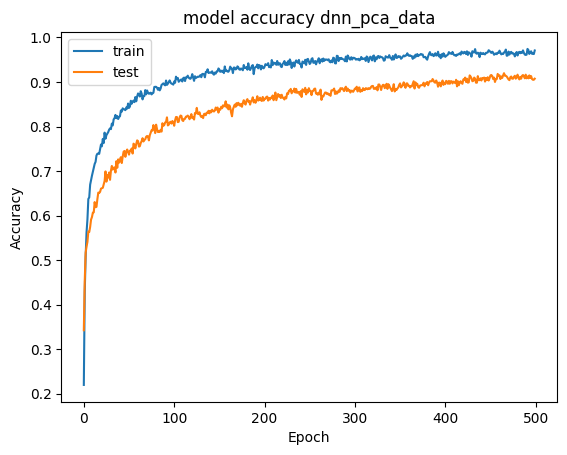

In [30]:
# base model
model = basemodel(len(reshaped_data))
history = train_dnn(model = model, X = np.squeeze(X_train, axis=2), Y = Y_train, test_X = np.squeeze(X_test, axis=2), test_Y = Y_test, cp_path = 'dnn_pca_data', Epoch=500)

2023-10-05 12:40:14.310777: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-05 12:40:14.889041: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18532 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:3b:00.0, compute capability: 8.6


X shape :  (4880, 301, 1)
Model: "resnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  multiple                 3         
 n)                                                              
                                                                 
 resnet_layer (ResnetLayer)  multiple                  24484     
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  2465920   
                                                                 
 dense_1 (Dense)             multiple                  8256      
                                                                 
 dense_2 (Dense)             multiple                  2080      
                                  

2023-10-05 12:40:17.888243: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-05 12:40:18.053080: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


153/153 [==============================] - ETA: 0s - loss: 1.5093 - accuracy: 0.5361 - categorical_crossentropy: 1.5093

INFO:tensorflow:Assets written to: ./model/resnet_pca_data/assets


INFO:tensorflow:Assets written to: ./model/resnet_pca_data/assets


153/153 [==============================] - 10s 42ms/step - loss: 1.5093 - accuracy: 0.5361 - categorical_crossentropy: 1.5093 - val_loss: 1.1958 - val_accuracy: 0.7049 - val_categorical_crossentropy: 1.1958
Epoch 2/500
150/153 [============================>.] - ETA: 0s - loss: 0.1729 - accuracy: 0.9467 - categorical_crossentropy: 0.1729

INFO:tensorflow:Assets written to: ./model/resnet_pca_data/assets


INFO:tensorflow:Assets written to: ./model/resnet_pca_data/assets


153/153 [==============================] - 6s 38ms/step - loss: 0.1766 - accuracy: 0.9459 - categorical_crossentropy: 0.1766 - val_loss: 0.5403 - val_accuracy: 0.8336 - val_categorical_crossentropy: 0.5403
Epoch 3/500
152/153 [============================>.] - ETA: 0s - loss: 0.0795 - accuracy: 0.9762 - categorical_crossentropy: 0.0795

INFO:tensorflow:Assets written to: ./model/resnet_pca_data/assets


INFO:tensorflow:Assets written to: ./model/resnet_pca_data/assets


153/153 [==============================] - 6s 38ms/step - loss: 0.0793 - accuracy: 0.9762 - categorical_crossentropy: 0.0793 - val_loss: 0.4339 - val_accuracy: 0.8721 - val_categorical_crossentropy: 0.4339
Epoch 4/500
153/153 [==============================] - 3s 18ms/step - loss: 0.0892 - accuracy: 0.9734 - categorical_crossentropy: 0.0892 - val_loss: 0.4211 - val_accuracy: 0.8631 - val_categorical_crossentropy: 0.4211
Epoch 5/500
151/153 [============================>.] - ETA: 0s - loss: 0.0959 - accuracy: 0.9710 - categorical_crossentropy: 0.0959

INFO:tensorflow:Assets written to: ./model/resnet_pca_data/assets


INFO:tensorflow:Assets written to: ./model/resnet_pca_data/assets


153/153 [==============================] - 5s 36ms/step - loss: 0.0953 - accuracy: 0.9711 - categorical_crossentropy: 0.0953 - val_loss: 0.4371 - val_accuracy: 0.8885 - val_categorical_crossentropy: 0.4371
Epoch 6/500
150/153 [============================>.] - ETA: 0s - loss: 0.0626 - accuracy: 0.9827 - categorical_crossentropy: 0.0626

INFO:tensorflow:Assets written to: ./model/resnet_pca_data/assets


INFO:tensorflow:Assets written to: ./model/resnet_pca_data/assets


153/153 [==============================] - 6s 38ms/step - loss: 0.0639 - accuracy: 0.9826 - categorical_crossentropy: 0.0639 - val_loss: 0.3330 - val_accuracy: 0.9139 - val_categorical_crossentropy: 0.3330
Epoch 7/500
153/153 [==============================] - 3s 18ms/step - loss: 0.0181 - accuracy: 0.9936 - categorical_crossentropy: 0.0181 - val_loss: 0.3411 - val_accuracy: 0.9066 - val_categorical_crossentropy: 0.3411
Epoch 8/500
153/153 [==============================] - 3s 18ms/step - loss: 0.0290 - accuracy: 0.9912 - categorical_crossentropy: 0.0290 - val_loss: 0.4747 - val_accuracy: 0.8869 - val_categorical_crossentropy: 0.4747
Epoch 9/500
153/153 [==============================] - 3s 18ms/step - loss: 0.0496 - accuracy: 0.9873 - categorical_crossentropy: 0.0496 - val_loss: 0.4946 - val_accuracy: 0.8992 - val_categorical_crossentropy: 0.4946
Epoch 10/500
153/153 [==============================] - 3s 19ms/step - loss: 0.0930 - accuracy: 0.9738 - categorical_crossentropy: 0.0930 - 

INFO:tensorflow:Assets written to: ./model/resnet_pca_data/assets


INFO:tensorflow:Assets written to: ./model/resnet_pca_data/assets


153/153 [==============================] - 6s 38ms/step - loss: 0.0173 - accuracy: 0.9939 - categorical_crossentropy: 0.0173 - val_loss: 0.3418 - val_accuracy: 0.9303 - val_categorical_crossentropy: 0.3418
Epoch 15/500
153/153 [==============================] - 3s 18ms/step - loss: 0.0190 - accuracy: 0.9959 - categorical_crossentropy: 0.0190 - val_loss: 0.3285 - val_accuracy: 0.9213 - val_categorical_crossentropy: 0.3285
Epoch 16/500
153/153 [==============================] - ETA: 0s - loss: 0.0071 - accuracy: 0.9988 - categorical_crossentropy: 0.0071

INFO:tensorflow:Assets written to: ./model/resnet_pca_data/assets


INFO:tensorflow:Assets written to: ./model/resnet_pca_data/assets


153/153 [==============================] - 5s 36ms/step - loss: 0.0071 - accuracy: 0.9988 - categorical_crossentropy: 0.0071 - val_loss: 0.3127 - val_accuracy: 0.9352 - val_categorical_crossentropy: 0.3127
Epoch 17/500
153/153 [==============================] - 3s 18ms/step - loss: 0.0250 - accuracy: 0.9945 - categorical_crossentropy: 0.0250 - val_loss: 0.6884 - val_accuracy: 0.8910 - val_categorical_crossentropy: 0.6884
Epoch 18/500
153/153 [==============================] - 3s 18ms/step - loss: 0.0358 - accuracy: 0.9914 - categorical_crossentropy: 0.0358 - val_loss: 0.4899 - val_accuracy: 0.9098 - val_categorical_crossentropy: 0.4899
Epoch 19/500
153/153 [==============================] - 3s 18ms/step - loss: 0.0726 - accuracy: 0.9830 - categorical_crossentropy: 0.0726 - val_loss: 0.5435 - val_accuracy: 0.9033 - val_categorical_crossentropy: 0.5435
Epoch 20/500
153/153 [==============================] - 3s 19ms/step - loss: 0.0407 - accuracy: 0.9875 - categorical_crossentropy: 0.0407

INFO:tensorflow:Assets written to: ./model/resnet_pca_data/assets


INFO:tensorflow:Assets written to: ./model/resnet_pca_data/assets


153/153 [==============================] - 6s 39ms/step - loss: 0.0061 - accuracy: 0.9984 - categorical_crossentropy: 0.0061 - val_loss: 0.3390 - val_accuracy: 0.9393 - val_categorical_crossentropy: 0.3390
Epoch 27/500
151/153 [============================>.] - ETA: 0s - loss: 0.0088 - accuracy: 0.9986 - categorical_crossentropy: 0.0088

INFO:tensorflow:Assets written to: ./model/resnet_pca_data/assets


INFO:tensorflow:Assets written to: ./model/resnet_pca_data/assets


153/153 [==============================] - 6s 40ms/step - loss: 0.0087 - accuracy: 0.9986 - categorical_crossentropy: 0.0087 - val_loss: 0.3245 - val_accuracy: 0.9451 - val_categorical_crossentropy: 0.3245
Epoch 28/500
153/153 [==============================] - 3s 18ms/step - loss: 0.0133 - accuracy: 0.9967 - categorical_crossentropy: 0.0133 - val_loss: 0.3900 - val_accuracy: 0.9377 - val_categorical_crossentropy: 0.3900
Epoch 29/500
153/153 [==============================] - 3s 19ms/step - loss: 0.0283 - accuracy: 0.9926 - categorical_crossentropy: 0.0283 - val_loss: 1.0850 - val_accuracy: 0.8852 - val_categorical_crossentropy: 1.0850
Epoch 30/500
153/153 [==============================] - 3s 18ms/step - loss: 0.1360 - accuracy: 0.9756 - categorical_crossentropy: 0.1360 - val_loss: 0.4242 - val_accuracy: 0.9148 - val_categorical_crossentropy: 0.4242
Epoch 31/500
153/153 [==============================] - 3s 19ms/step - loss: 0.0240 - accuracy: 0.9936 - categorical_crossentropy: 0.0240

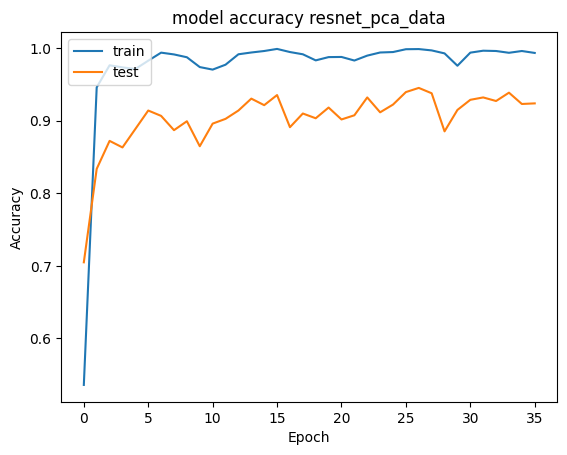

In [23]:
# non_norm_model = non_norm(len(range_fft_dict))

# base model
# model = basemodel(len(range_fft_dict))

# Resnet
filter_in_list = [1, 32]
filter_out_list = [32, 64]
kernel_size = 3
model = Resnet(filter_in = filter_in_list, filters = filter_out_list, kernel_size = kernel_size, out_nums=len(reshaped_data))
history = train(model = model, X = X_train, Y = Y_train, test_X = X_test, test_Y = Y_test, cp_path = 'resnet_pca_data', Epoch=500)

X shape :  (3264, 301, 1)
Model: "resnet_regression_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_9 (Normalizat  multiple                 3         
 ion)                                                            
                                                                 
 resnet_layer_9 (ResnetLayer  multiple                 24484     
 )                                                               
                                                                 
 flatten_9 (Flatten)         multiple                  0         
                                                                 
 dense_36 (Dense)            multiple                  2465920   
                                                                 
 dense_37 (Dense)            multiple                  8256      
                                                                 
 dense_38 (Dense)    

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 44ms/step - loss: 2401.3000 - mae: 12.0921 - mse: 2401.3000 - val_loss: 15.8238 - val_mae: 3.2392 - val_mse: 15.8238
Epoch 2/500
101/102 [============================>.] - ETA: 0s - loss: 14.6274 - mae: 3.0670 - mse: 14.6274

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 47ms/step - loss: 14.5460 - mae: 3.0572 - mse: 14.5460 - val_loss: 14.5178 - val_mae: 3.0693 - val_mse: 14.5178
Epoch 3/500
102/102 [==============================] - 2s 15ms/step - loss: 19.7360 - mae: 3.5608 - mse: 19.7360 - val_loss: 19.1450 - val_mae: 3.6171 - val_mse: 19.1450
Epoch 4/500
102/102 [==============================] - ETA: 0s - loss: 13.9346 - mae: 2.9841 - mse: 13.9346

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 13.9346 - mae: 2.9841 - mse: 13.9346 - val_loss: 12.4459 - val_mae: 2.8901 - val_mse: 12.4459
Epoch 5/500
102/102 [==============================] - 2s 16ms/step - loss: 20.8219 - mae: 3.6790 - mse: 20.8219 - val_loss: 16.5947 - val_mae: 3.3989 - val_mse: 16.5947
Epoch 6/500
102/102 [==============================] - 2s 15ms/step - loss: 15.7487 - mae: 3.1919 - mse: 15.7487 - val_loss: 27.3781 - val_mae: 4.4048 - val_mse: 27.3781
Epoch 7/500
102/102 [==============================] - 2s 15ms/step - loss: 20.9155 - mae: 3.6465 - mse: 20.9155 - val_loss: 30.0095 - val_mae: 4.6575 - val_mse: 30.0095
Epoch 8/500
102/102 [==============================] - 2s 15ms/step - loss: 13.3131 - mae: 2.9068 - mse: 13.3131 - val_loss: 13.7295 - val_mae: 3.0526 - val_mse: 13.7295
Epoch 9/500
102/102 [==============================] - 2s 15ms/step - loss: 14.2284 - mae: 3.0169 - mse: 14.2284 - val_loss: 13.9482 - val_mae: 2.9976 - val_mse: 

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 48ms/step - loss: 12.6945 - mae: 2.8490 - mse: 12.6945 - val_loss: 8.9177 - val_mae: 2.4114 - val_mse: 8.9177
Epoch 11/500
102/102 [==============================] - 2s 16ms/step - loss: 15.0984 - mae: 3.1006 - mse: 15.0984 - val_loss: 20.8991 - val_mae: 3.8295 - val_mse: 20.8991
Epoch 12/500
100/102 [============================>.] - ETA: 0s - loss: 12.0503 - mae: 2.7765 - mse: 12.0503

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 11.9842 - mae: 2.7678 - mse: 11.9842 - val_loss: 7.7669 - val_mae: 2.2147 - val_mse: 7.7669
Epoch 13/500
100/102 [============================>.] - ETA: 0s - loss: 12.7857 - mae: 2.8585 - mse: 12.7857

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 12.7118 - mae: 2.8511 - mse: 12.7118 - val_loss: 7.1334 - val_mae: 2.1387 - val_mse: 7.1334
Epoch 14/500
102/102 [==============================] - 2s 16ms/step - loss: 12.6922 - mae: 2.8788 - mse: 12.6922 - val_loss: 9.9306 - val_mae: 2.5714 - val_mse: 9.9306
Epoch 15/500
102/102 [==============================] - 2s 16ms/step - loss: 15.4454 - mae: 3.1421 - mse: 15.4454 - val_loss: 16.1398 - val_mae: 3.3188 - val_mse: 16.1398
Epoch 16/500
102/102 [==============================] - 2s 16ms/step - loss: 7.7016 - mae: 2.2122 - mse: 7.7016 - val_loss: 8.9553 - val_mae: 2.4690 - val_mse: 8.9553
Epoch 17/500
101/102 [============================>.] - ETA: 0s - loss: 7.6659 - mae: 2.1861 - mse: 7.6659

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 48ms/step - loss: 7.6857 - mae: 2.1883 - mse: 7.6857 - val_loss: 5.0222 - val_mae: 1.7685 - val_mse: 5.0222
Epoch 18/500
100/102 [============================>.] - ETA: 0s - loss: 5.4965 - mae: 1.8478 - mse: 5.4965

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 5.5225 - mae: 1.8507 - mse: 5.5225 - val_loss: 4.8343 - val_mae: 1.7480 - val_mse: 4.8343
Epoch 19/500
101/102 [============================>.] - ETA: 0s - loss: 7.0941 - mae: 2.1085 - mse: 7.0941

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 41ms/step - loss: 7.1015 - mae: 2.1081 - mse: 7.1015 - val_loss: 4.7884 - val_mae: 1.7508 - val_mse: 4.7884
Epoch 20/500
101/102 [============================>.] - ETA: 0s - loss: 6.9637 - mae: 2.0916 - mse: 6.9637

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 48ms/step - loss: 6.9354 - mae: 2.0877 - mse: 6.9354 - val_loss: 4.6044 - val_mae: 1.7194 - val_mse: 4.6044
Epoch 21/500
102/102 [==============================] - 2s 15ms/step - loss: 6.0443 - mae: 1.9518 - mse: 6.0443 - val_loss: 6.9587 - val_mae: 2.1764 - val_mse: 6.9587
Epoch 22/500
 98/102 [===========================>..] - ETA: 0s - loss: 6.0539 - mae: 1.9375 - mse: 6.0539

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 5.9889 - mae: 1.9294 - mse: 5.9889 - val_loss: 4.0048 - val_mae: 1.5618 - val_mse: 4.0048
Epoch 23/500
102/102 [==============================] - 1s 14ms/step - loss: 5.9573 - mae: 1.9441 - mse: 5.9573 - val_loss: 4.0735 - val_mae: 1.5957 - val_mse: 4.0735
Epoch 24/500
102/102 [==============================] - ETA: 0s - loss: 4.3689 - mae: 1.6432 - mse: 4.3689

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 47ms/step - loss: 4.3689 - mae: 1.6432 - mse: 4.3689 - val_loss: 3.8140 - val_mae: 1.5498 - val_mse: 3.8140
Epoch 25/500
102/102 [==============================] - ETA: 0s - loss: 5.1409 - mae: 1.7960 - mse: 5.1409

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 5.1409 - mae: 1.7960 - mse: 5.1409 - val_loss: 3.7635 - val_mae: 1.5171 - val_mse: 3.7635
Epoch 26/500
102/102 [==============================] - 2s 15ms/step - loss: 3.5220 - mae: 1.4718 - mse: 3.5220 - val_loss: 4.4010 - val_mae: 1.6169 - val_mse: 4.4010
Epoch 27/500
102/102 [==============================] - 2s 15ms/step - loss: 4.0959 - mae: 1.5994 - mse: 4.0959 - val_loss: 5.0757 - val_mae: 1.7706 - val_mse: 5.0757
Epoch 28/500
102/102 [==============================] - 2s 16ms/step - loss: 3.5920 - mae: 1.4807 - mse: 3.5920 - val_loss: 4.2598 - val_mae: 1.6570 - val_mse: 4.2598
Epoch 29/500
102/102 [==============================] - 2s 15ms/step - loss: 3.3147 - mae: 1.4139 - mse: 3.3147 - val_loss: 3.8176 - val_mae: 1.5297 - val_mse: 3.8176
Epoch 30/500
102/102 [==============================] - 2s 15ms/step - loss: 2.9702 - mae: 1.3712 - mse: 2.9702 - val_loss: 5.2518 - val_mae: 1.7995 - val_mse: 5.2518
Epoch 31/50

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 3.1755 - mae: 1.4132 - mse: 3.1755 - val_loss: 2.8517 - val_mae: 1.3033 - val_mse: 2.8517
Epoch 32/500
102/102 [==============================] - 2s 15ms/step - loss: 4.2045 - mae: 1.6010 - mse: 4.2045 - val_loss: 3.3619 - val_mae: 1.4245 - val_mse: 3.3619
Epoch 33/500
102/102 [==============================] - 2s 15ms/step - loss: 26.6353 - mae: 2.2073 - mse: 26.6353 - val_loss: 52.5412 - val_mae: 6.1846 - val_mse: 52.5412
Epoch 34/500
102/102 [==============================] - 2s 15ms/step - loss: 16.3630 - mae: 3.1866 - mse: 16.3630 - val_loss: 7.4690 - val_mae: 2.2107 - val_mse: 7.4690
Epoch 35/500
102/102 [==============================] - 2s 15ms/step - loss: 7.1629 - mae: 2.1333 - mse: 7.1629 - val_loss: 5.9703 - val_mae: 1.9535 - val_mse: 5.9703
Epoch 36/500
102/102 [==============================] - 2s 15ms/step - loss: 5.6321 - mae: 1.8873 - mse: 5.6321 - val_loss: 5.5855 - val_mae: 1.8912 - val_mse: 5.5855
Epoch

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 48ms/step - loss: 2.3480 - mae: 1.1718 - mse: 2.3480 - val_loss: 2.7269 - val_mae: 1.2867 - val_mse: 2.7269
Epoch 47/500
102/102 [==============================] - 2s 16ms/step - loss: 2.4970 - mae: 1.2140 - mse: 2.4970 - val_loss: 2.7894 - val_mae: 1.3054 - val_mse: 2.7894
Epoch 48/500
102/102 [==============================] - 2s 16ms/step - loss: 1.8136 - mae: 1.0415 - mse: 1.8136 - val_loss: 2.7935 - val_mae: 1.3186 - val_mse: 2.7935
Epoch 49/500
100/102 [============================>.] - ETA: 0s - loss: 1.7052 - mae: 1.0098 - mse: 1.7052

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 1.7064 - mae: 1.0097 - mse: 1.7064 - val_loss: 2.5622 - val_mae: 1.2276 - val_mse: 2.5622
Epoch 50/500
102/102 [==============================] - 2s 15ms/step - loss: 1.5787 - mae: 0.9696 - mse: 1.5787 - val_loss: 2.7976 - val_mae: 1.2829 - val_mse: 2.7976
Epoch 51/500
102/102 [==============================] - 2s 15ms/step - loss: 1.5701 - mae: 0.9673 - mse: 1.5701 - val_loss: 3.6444 - val_mae: 1.5163 - val_mse: 3.6444
Epoch 52/500
100/102 [============================>.] - ETA: 0s - loss: 1.4416 - mae: 0.9162 - mse: 1.4416

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 46ms/step - loss: 1.4390 - mae: 0.9150 - mse: 1.4390 - val_loss: 2.3186 - val_mae: 1.1745 - val_mse: 2.3186
Epoch 53/500
100/102 [============================>.] - ETA: 0s - loss: 1.3655 - mae: 0.8975 - mse: 1.3655

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 1.3667 - mae: 0.8983 - mse: 1.3667 - val_loss: 2.1679 - val_mae: 1.1323 - val_mse: 2.1679
Epoch 54/500
100/102 [============================>.] - ETA: 0s - loss: 1.3354 - mae: 0.8857 - mse: 1.3354

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 1.3315 - mae: 0.8827 - mse: 1.3315 - val_loss: 2.0915 - val_mae: 1.1103 - val_mse: 2.0915
Epoch 55/500
102/102 [==============================] - ETA: 0s - loss: 1.2466 - mae: 0.8635 - mse: 1.2466

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 48ms/step - loss: 1.2466 - mae: 0.8635 - mse: 1.2466 - val_loss: 2.0906 - val_mae: 1.1227 - val_mse: 2.0906
Epoch 56/500
102/102 [==============================] - 2s 15ms/step - loss: 1.1839 - mae: 0.8395 - mse: 1.1839 - val_loss: 2.0975 - val_mae: 1.0992 - val_mse: 2.0975
Epoch 57/500
102/102 [==============================] - 2s 15ms/step - loss: 1.1663 - mae: 0.8272 - mse: 1.1663 - val_loss: 2.1728 - val_mae: 1.1209 - val_mse: 2.1728
Epoch 58/500
 99/102 [============================>.] - ETA: 0s - loss: 1.0570 - mae: 0.7958 - mse: 1.0570

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 41ms/step - loss: 1.0597 - mae: 0.7978 - mse: 1.0597 - val_loss: 2.0608 - val_mae: 1.0786 - val_mse: 2.0608
Epoch 59/500
102/102 [==============================] - ETA: 0s - loss: 1.0617 - mae: 0.7927 - mse: 1.0617

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 46ms/step - loss: 1.0617 - mae: 0.7927 - mse: 1.0617 - val_loss: 1.9994 - val_mae: 1.0537 - val_mse: 1.9994
Epoch 60/500
 99/102 [============================>.] - ETA: 0s - loss: 1.0775 - mae: 0.8073 - mse: 1.0775

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 1.0783 - mae: 0.8048 - mse: 1.0783 - val_loss: 1.8571 - val_mae: 1.0353 - val_mse: 1.8571
Epoch 61/500
102/102 [==============================] - 2s 15ms/step - loss: 0.9244 - mae: 0.7421 - mse: 0.9244 - val_loss: 2.1956 - val_mae: 1.0946 - val_mse: 2.1956
Epoch 62/500
102/102 [==============================] - 2s 16ms/step - loss: 1.0096 - mae: 0.7771 - mse: 1.0096 - val_loss: 1.9496 - val_mae: 1.0115 - val_mse: 1.9496
Epoch 63/500
102/102 [==============================] - 2s 16ms/step - loss: 0.8798 - mae: 0.7230 - mse: 0.8798 - val_loss: 2.0643 - val_mae: 1.0614 - val_mse: 2.0643
Epoch 64/500
101/102 [============================>.] - ETA: 0s - loss: 1.0394 - mae: 0.7936 - mse: 1.0394

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 1.0355 - mae: 0.7919 - mse: 1.0355 - val_loss: 1.7620 - val_mae: 0.9954 - val_mse: 1.7620
Epoch 65/500
102/102 [==============================] - 2s 16ms/step - loss: 0.7959 - mae: 0.6950 - mse: 0.7959 - val_loss: 1.7645 - val_mae: 0.9718 - val_mse: 1.7645
Epoch 66/500
102/102 [==============================] - 2s 15ms/step - loss: 0.7371 - mae: 0.6630 - mse: 0.7371 - val_loss: 1.9203 - val_mae: 1.0212 - val_mse: 1.9203
Epoch 67/500
102/102 [==============================] - 2s 15ms/step - loss: 0.6738 - mae: 0.6340 - mse: 0.6738 - val_loss: 2.4361 - val_mae: 1.1748 - val_mse: 2.4361
Epoch 68/500
102/102 [==============================] - 2s 15ms/step - loss: 0.6948 - mae: 0.6504 - mse: 0.6948 - val_loss: 1.9890 - val_mae: 1.0691 - val_mse: 1.9890
Epoch 69/500
102/102 [==============================] - 2s 15ms/step - loss: 0.6613 - mae: 0.6334 - mse: 0.6613 - val_loss: 1.7711 - val_mae: 0.9445 - val_mse: 1.7711
Epoch 70/50

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 48ms/step - loss: 0.5873 - mae: 0.6016 - mse: 0.5873 - val_loss: 1.6692 - val_mae: 0.9076 - val_mse: 1.6692
Epoch 72/500
102/102 [==============================] - 2s 16ms/step - loss: 0.5919 - mae: 0.6010 - mse: 0.5919 - val_loss: 1.7299 - val_mae: 0.9568 - val_mse: 1.7299
Epoch 73/500
102/102 [==============================] - 2s 15ms/step - loss: 0.5886 - mae: 0.5914 - mse: 0.5886 - val_loss: 1.9116 - val_mae: 0.9903 - val_mse: 1.9116
Epoch 74/500
102/102 [==============================] - 2s 15ms/step - loss: 0.8842 - mae: 0.7214 - mse: 0.8842 - val_loss: 1.9108 - val_mae: 0.9964 - val_mse: 1.9108
Epoch 75/500
 99/102 [============================>.] - ETA: 0s - loss: 0.8336 - mae: 0.7022 - mse: 0.8336

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 41ms/step - loss: 0.8333 - mae: 0.7012 - mse: 0.8333 - val_loss: 1.6159 - val_mae: 0.9169 - val_mse: 1.6159
Epoch 76/500
102/102 [==============================] - 2s 16ms/step - loss: 1.1816 - mae: 0.6743 - mse: 1.1816 - val_loss: 40.7677 - val_mae: 5.5069 - val_mse: 40.7677
Epoch 77/500
102/102 [==============================] - 2s 16ms/step - loss: 5.9906 - mae: 1.7720 - mse: 5.9906 - val_loss: 2.9087 - val_mae: 1.3010 - val_mse: 2.9087
Epoch 78/500
102/102 [==============================] - 2s 15ms/step - loss: 1.4412 - mae: 0.9344 - mse: 1.4412 - val_loss: 2.4674 - val_mae: 1.1493 - val_mse: 2.4674
Epoch 79/500
102/102 [==============================] - 2s 16ms/step - loss: 0.9602 - mae: 0.7657 - mse: 0.9602 - val_loss: 1.9764 - val_mae: 1.0591 - val_mse: 1.9764
Epoch 80/500
102/102 [==============================] - 2s 15ms/step - loss: 0.8893 - mae: 0.7343 - mse: 0.8893 - val_loss: 3.2197 - val_mae: 1.4053 - val_mse: 3.2197
Epoch 81/

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 0.3521 - mae: 0.4658 - mse: 0.3521 - val_loss: 1.5476 - val_mae: 0.8887 - val_mse: 1.5476
Epoch 91/500
102/102 [==============================] - 2s 15ms/step - loss: 0.3538 - mae: 0.4625 - mse: 0.3538 - val_loss: 1.6913 - val_mae: 0.9244 - val_mse: 1.6913
Epoch 92/500
102/102 [==============================] - 2s 15ms/step - loss: 0.3257 - mae: 0.4453 - mse: 0.3257 - val_loss: 1.6662 - val_mae: 0.9235 - val_mse: 1.6662
Epoch 93/500
102/102 [==============================] - 2s 15ms/step - loss: 0.2738 - mae: 0.4121 - mse: 0.2738 - val_loss: 1.6223 - val_mae: 0.8911 - val_mse: 1.6223
Epoch 94/500
102/102 [==============================] - 2s 15ms/step - loss: 0.3095 - mae: 0.4347 - mse: 0.3095 - val_loss: 1.6591 - val_mae: 0.9007 - val_mse: 1.6591
Epoch 95/500
102/102 [==============================] - 2s 15ms/step - loss: 0.2589 - mae: 0.3966 - mse: 0.2589 - val_loss: 1.6342 - val_mae: 0.9429 - val_mse: 1.6342
Epoch 96/50

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 48ms/step - loss: 0.2346 - mae: 0.3805 - mse: 0.2346 - val_loss: 1.4538 - val_mae: 0.8504 - val_mse: 1.4538
Epoch 97/500
102/102 [==============================] - 2s 15ms/step - loss: 0.2443 - mae: 0.3851 - mse: 0.2443 - val_loss: 1.5887 - val_mae: 0.9225 - val_mse: 1.5887
Epoch 98/500
102/102 [==============================] - 2s 15ms/step - loss: 0.2987 - mae: 0.4243 - mse: 0.2987 - val_loss: 1.7635 - val_mae: 0.9390 - val_mse: 1.7635
Epoch 99/500
102/102 [==============================] - 2s 15ms/step - loss: 0.2681 - mae: 0.4074 - mse: 0.2681 - val_loss: 1.5148 - val_mae: 0.8814 - val_mse: 1.5148
Epoch 100/500
102/102 [==============================] - 2s 16ms/step - loss: 0.2506 - mae: 0.3946 - mse: 0.2506 - val_loss: 2.2511 - val_mae: 1.1555 - val_mse: 2.2511
Epoch 101/500
102/102 [==============================] - 2s 15ms/step - loss: 0.3056 - mae: 0.4335 - mse: 0.3056 - val_loss: 1.5900 - val_mae: 0.8766 - val_mse: 1.5900
Epoch 102

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 0.2063 - mae: 0.3562 - mse: 0.2063 - val_loss: 1.4153 - val_mae: 0.8254 - val_mse: 1.4153
Epoch 115/500
102/102 [==============================] - 2s 15ms/step - loss: 0.2116 - mae: 0.3539 - mse: 0.2116 - val_loss: 1.4323 - val_mae: 0.8305 - val_mse: 1.4323
Epoch 116/500
102/102 [==============================] - 1s 15ms/step - loss: 0.1794 - mae: 0.3293 - mse: 0.1794 - val_loss: 1.7712 - val_mae: 0.9259 - val_mse: 1.7712
Epoch 117/500
102/102 [==============================] - 1s 14ms/step - loss: 0.2000 - mae: 0.3515 - mse: 0.2000 - val_loss: 1.5928 - val_mae: 0.8922 - val_mse: 1.5928
Epoch 118/500
102/102 [==============================] - 2s 16ms/step - loss: 0.1193 - mae: 0.2711 - mse: 0.1193 - val_loss: 1.5743 - val_mae: 0.8954 - val_mse: 1.5743
Epoch 119/500
102/102 [==============================] - 2s 16ms/step - loss: 0.1577 - mae: 0.3078 - mse: 0.1577 - val_loss: 1.5170 - val_mae: 0.8411 - val_mse: 1.5170
Epoch 

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 47ms/step - loss: 0.1364 - mae: 0.2925 - mse: 0.1364 - val_loss: 1.3583 - val_mae: 0.8101 - val_mse: 1.3583
Epoch 128/500
102/102 [==============================] - 2s 16ms/step - loss: 0.0998 - mae: 0.2478 - mse: 0.0998 - val_loss: 1.3738 - val_mae: 0.8034 - val_mse: 1.3738
Epoch 129/500
 99/102 [============================>.] - ETA: 0s - loss: 0.0893 - mae: 0.2330 - mse: 0.0893

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 5s 45ms/step - loss: 0.0892 - mae: 0.2329 - mse: 0.0892 - val_loss: 1.3357 - val_mae: 0.8181 - val_mse: 1.3357
Epoch 130/500
102/102 [==============================] - 2s 15ms/step - loss: 0.1050 - mae: 0.2560 - mse: 0.1050 - val_loss: 1.3729 - val_mae: 0.8145 - val_mse: 1.3729
Epoch 131/500
102/102 [==============================] - 2s 16ms/step - loss: 0.0871 - mae: 0.2290 - mse: 0.0871 - val_loss: 1.4004 - val_mae: 0.8370 - val_mse: 1.4004
Epoch 132/500
100/102 [============================>.] - ETA: 0s - loss: 0.1009 - mae: 0.2522 - mse: 0.1009

INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


INFO:tensorflow:Assets written to: ./model/resnet_range_fft_regression/assets


102/102 [==============================] - 4s 42ms/step - loss: 0.1008 - mae: 0.2523 - mse: 0.1008 - val_loss: 1.3289 - val_mae: 0.8015 - val_mse: 1.3289
Epoch 133/500
102/102 [==============================] - 2s 15ms/step - loss: 0.1040 - mae: 0.2531 - mse: 0.1040 - val_loss: 1.4490 - val_mae: 0.8293 - val_mse: 1.4490
Epoch 134/500
102/102 [==============================] - 2s 16ms/step - loss: 0.0759 - mae: 0.2165 - mse: 0.0759 - val_loss: 1.3897 - val_mae: 0.8101 - val_mse: 1.3897
Epoch 135/500
102/102 [==============================] - 2s 15ms/step - loss: 0.1438 - mae: 0.2855 - mse: 0.1438 - val_loss: 1.5011 - val_mae: 0.8399 - val_mse: 1.5011
Epoch 136/500
102/102 [==============================] - 2s 15ms/step - loss: 0.6515 - mae: 0.5240 - mse: 0.6515 - val_loss: 5.0691 - val_mae: 1.7616 - val_mse: 5.0691
Epoch 137/500
102/102 [==============================] - 2s 15ms/step - loss: 1562.7550 - mae: 20.0757 - mse: 1562.7550 - val_loss: 21.8882 - val_mae: 3.9101 - val_mse: 21.88

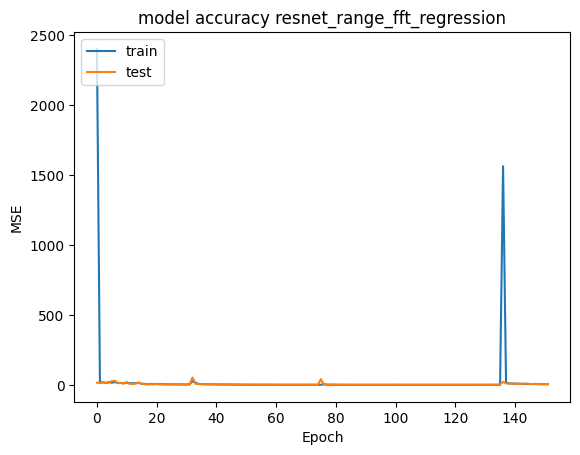

In [38]:
loss = tf.keras.losses.MeanSquaredError()
metrics = ['mae', 'mse']
model = Resnet_regression(filter_in = filter_in_list, filters = filter_out_list, kernel_size = kernel_size, out_nums=len(range_fft_dict))
# reg_Y_train, reg_Y_test = np.argmax(Y_train, axis = 1), np.argmax(Y_test, axis = 1)
history = train_regression(model = model, X = X_train, Y = np.argmax(Y_train, axis=1), test_X = X_test, test_Y = np.argmax(Y_test, axis=1), cp_path = 'resnet_range_fft_regression', Epoch=500, loss = loss, metrics = metrics, monitor='val_mse', mode='min')